<h1> Building A Traffic Collision Prediction Model </h1>

This notebook will involve data wrangling, feature engineering and building a prediction model using supervised learning to predict the severity of an accident given attributes of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
pd.set_option('display.max_columns',50)
df = pd.read_csv(r'Data-Collisions.csv', parse_dates = ['INCDATE'])
df.head()

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


SEVERITYCODE           X          Y  OBJECTID  INCKEY  COLDETKEY REPORTNO  \
0             2 -122.323148  47.703140         1    1307       1307  3502005   
1             1 -122.347294  47.647172         2   52200      52200  2607959   
2             1 -122.334540  47.607871         3   26700      26700  1482393   
3             1 -122.334803  47.604803         4    1144       1144  3503937   
4             2 -122.306426  47.545739         5   17700      17700  1807429   

    STATUS      ADDRTYPE   INTKEY  \
0  Matched  Intersection  37475.0   
1  Matched         Block      NaN   
2  Matched         Block      NaN   
3  Matched         Block      NaN   
4  Matched  Intersection  34387.0   

                                      LOCATION EXCEPTRSNCODE EXCEPTRSNDESC  \
0                   5TH AVE NE AND NE 103RD ST                         NaN   
1   AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N           NaN           NaN   
2  4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST           NaN           NaN   
3     2ND AVE BETWEEN MARION ST AND MADISON ST                         NaN   
4              SWIFT AVE S AND SWIFT AV OFF RP           NaN           NaN   

   SEVERITYCODE.1                    SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  \
0               2                Injury Collision        Angles            2   
1               1  Property Damage Only Collision     Sideswipe            2   
2               1  Property Damage Only Collision    Parked Car            4   
3               1  Property Damage Only Collision         Other            3   
4               2                Injury Collision        Angles            2   

   PEDCOUNT  PEDCYLCOUNT  VEHCOUNT                   INCDATE  \
0         0            0         2 2013-03-27 00:00:00+00:00   
1         0            0         2 2006-12-20 00:00:00+00:00   
2         0            0         3 2004-11-18 00:00:00+00:00   
3         0            0         3 2013-03-29 00:00:00+00:00   
4         0            0         2 2004-01-28 00:00:00+00:00   

                  INCDTTM                             JUNCTIONTYPE  \
0    3/27/2013 2:54:00 PM   At Intersection (intersection related)   
1   12/20/2006 6:55:00 PM  Mid-Block (not related to intersection)   
2  11/18/2004 10:20:00 AM  Mid-Block (not related to intersection)   
3    3/29/2013 9:26:00 AM  Mid-Block (not related to intersection)   
4    1/28/2004 8:04:00 AM   At Intersection (intersection related)   

   SDOT_COLCODE                                       SDOT_COLDESC  \
0            11  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...   
1            16  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...   
2            14       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END   
3            11  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...   
4            11  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...   

  INATTENTIONIND UNDERINFL   WEATHER ROADCOND                LIGHTCOND  \
0            NaN         N  Overcast      Wet                 Daylight   
1            NaN         0   Raining      Wet  Dark - Street Lights On   
2            NaN         0  Overcast      Dry                 Daylight   
3            NaN         N     Clear      Dry                 Daylight   
4            NaN         0   Raining      Wet                 Daylight   

  PEDROWNOTGRNT  SDOTCOLNUM SPEEDING ST_COLCODE  \
0           NaN         NaN      NaN         10   
1           NaN   6354039.0      NaN         11   
2           NaN   4323031.0      NaN         32   
3           NaN         NaN      NaN         23   
4           NaN   4028032.0      NaN         10   

                                          ST_COLDESC  SEGLANEKEY  \
0                                  Entering at angle           0   
1  From same direction - both going straight - bo...           0   
2                             One parked--one moving           0   
3                   From same direction - all others           0   
4                             

<h1> Cleaning the Data </h1>

In this dataset, the columns SEVERITYCODE and SEVERITYCODE.1 are identical to each other and convey the same information. Hence in the following step, it is dropped.

In [3]:
df.drop('SEVERITYCODE.1',axis = 1, inplace = True)

In [4]:
#drop the unique key for incident,secondary key for incident,report no. as they dont contribute to prediction of severity
df.drop(['INCKEY','COLDETKEY','REPORTNO'],axis = 1, inplace = True)

The UNDERIFL column contains 4 different values. Y,1,N,0 and NaN. It is necessary to make the column consistent to have only **1 for Under the Influence and 0 for Not Under the Influence** Filling up the missing values and making consistent binary indications in the Under Influence columns

In [5]:
df['UNDERINFL'].unique()

array(['N', '0', nan, '1', 'Y'], dtype=object)

In [6]:
df.loc[(df['UNDERINFL'] == 'Y'),'UNDERINFL'] = 1
df.loc[(df['UNDERINFL'] == 'N'),'UNDERINFL'] = 0
df.loc[(df['UNDERINFL'] == '1'),'UNDERINFL'] = 1
df.loc[(df['UNDERINFL'] == '0'),'UNDERINFL'] = 0
df['UNDERINFL'].unique()

array([0, nan, 1], dtype=object)

In [7]:
temp = df[['SEVERITYCODE','SEVERITYDESC']]
temp[~(temp.duplicated())]

SEVERITYCODE                    SEVERITYDESC
0             2                Injury Collision
1             1  Property Damage Only Collision

In [8]:
df['UNDERINFL'].isna().value_counts()

False    189789
True       4884
Name: UNDERINFL, dtype: int64

This dataset has only 2 severity levels

These 2 functions serve to find the percentage of Missing Values in each column and then produce a Dataframe of these results to help up get a better understanding of the missing data.

In [9]:
def missingvaluepercentages(features,datafr):
    numberofnanvalues = []
    nanvaluepercentage = []
    featureswithnan = []
    totalvalues = datafr.shape[0]
    for feature in features:
        try:
            nanvalues = datafr[feature].isna().value_counts()[1]
        except:
            nanvalues = 0
        numberofnanvalues.append(nanvalues)
        if nanvalues > 0:
            nanvaluepercent = ((nanvalues/totalvalues)*100).round(2)
        else:
            nanvaluepercent = 0.00
        nanvaluepercentage.append(nanvaluepercent)
        featureswithnan.append(feature)
            
    return numberofnanvalues,nanvaluepercentage,featureswithnan


def visualizemissingdata(numberofnanvalues,nanvaluepercentage,features):
    #order from highest to lowest for nanvalues and nanvalue%
    idx = np.array(numberofnanvalues).argsort()[::-1]
    nanvaluearray = np.array(numberofnanvalues)[idx]
    nanvaluepercentagearray = np.array(nanvaluepercentage)[idx]
    featuresarray = np.array(features)[idx]
    data = np.concatenate([nanvaluearray.reshape(1,-1),nanvaluepercentagearray.reshape(1,-1)],axis = 0)
    missingvaluedf = pd.DataFrame(data = data, columns = featuresarray, 
                                  index = ['Missing Value Number','Missing Value Percentage'])
    return missingvaluedf
    


In [10]:
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)

In [11]:
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)

In [12]:
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

<h3> Analysis </h3>

98% of the data in column **PEDROWNOTGRNT** is missing and we are not in a position to speculate if the Pedestrian was granted the right of way given the lack of information. Furthermore, both columns **EXCEPTRSDESC** and **EXCEPTRSNCODE** only have Not Enough Information as it's only available data, hence this isn't enough to make any conclusive action on the missing data of these columns. 

**INTKEY** is a key to each intersection. While intersections can have experience more collisions, which will be investigated later using box plots and barcharts, this column which already has so much of NaN values, can be removed.

**INATTENTIONIND** also has a large number of missing values. While we could replace the missing values with 'N', given the number of missing values, it would be an unnecessary amount of speculation. Hence we drop this column too. 

**SDOTCOLNUM** is only a reference number given to each collision, and has no impact on our prediction model. Hence we may remove this column too. 

In [13]:
df.drop(['PEDROWNOTGRNT','EXCEPTRSNDESC','EXCEPTRSNCODE','INTKEY','INATTENTIONIND','SDOTCOLNUM'],axis = 1,inplace = True)

In [14]:
#visualizing missing data after dropping the above columns
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

<h3> Analysis </h3>
Now the main culprit is from the **SPEEDING** column, however it is safe to assume that while Y represents cases where speeding was involved, the missing values represent cases where speeding was not involved

In [15]:
#replacing 'Y' with 1 and Missing Values with 0 in the SPEEDING Column
df.loc[(df['SPEEDING'] == 'Y'),'SPEEDING'] = 1
df.loc[(df['SPEEDING'].isna()),'SPEEDING'] = 0
df['SPEEDING'].value_counts()

0    185340
1      9333
Name: SPEEDING, dtype: int64

In [16]:
#visualizing missing data after adjusting the speeding column
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

In [17]:
#drop the LOCATION column
df.drop(['LOCATION'],axis = 1,inplace = True)

In [18]:
df['UNDERINFL'].value_counts(dropna = False)

0.0    180668
1.0      9121
NaN      4884
Name: UNDERINFL, dtype: int64

<h3> Analysis </h3>

We shall drop all the NaN values off these columns. Note that **Unknown** and **Other** instances are still present in these columns. 


In [19]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
#df['SDOT_COLCODE'].replace(to_replace = {0:np.nan},inplace = True)
#df['SDOT_COLDESC'].replace(to_replace = {'NOT ENOUGH INFORMATION / NOT APPLICABLE':np.nan},inplace = True)

In [20]:
#visualizing missing data after replacing the Unknown and Others values
features = df.columns.tolist()
nanvaluenumber,nanvaluepercentage,featureshavingnan = missingvaluepercentages(features,df)
missingvaldf = visualizemissingdata(nanvaluenumber,nanvaluepercentage,featureshavingnan)
display(missingvaldf.style.background_gradient(cmap = 'Reds',axis = 1))

Collision codes are worth investigating into to see if certain collisions have effect on the severity. Hence while we drop the description column of each collision, we keep the collision code column. 

In [21]:
st_colcode = df[['ST_COLCODE','ST_COLDESC']]
st_colcodefinal = st_colcode[~(st_colcode.duplicated())].style.hide_index()
sdot_colcode = df[['SDOT_COLCODE','SDOT_COLDESC']]
sdot_colcodefinal = sdot_colcode[~(sdot_colcode.duplicated())].style.hide_index()

In [22]:
df.drop(['ST_COLDESC','SDOT_COLDESC'],axis = 1, inplace = True)

In [23]:
df.head()

SEVERITYCODE           X          Y  OBJECTID   STATUS      ADDRTYPE  \
0             2 -122.323148  47.703140         1  Matched  Intersection   
1             1 -122.347294  47.647172         2  Matched         Block   
2             1 -122.334540  47.607871         3  Matched         Block   
3             1 -122.334803  47.604803         4  Matched         Block   
4             2 -122.306426  47.545739         5  Matched  Intersection   

                     SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0                Injury Collision        Angles            2         0   
1  Property Damage Only Collision     Sideswipe            2         0   
2  Property Damage Only Collision    Parked Car            4         0   
3  Property Damage Only Collision         Other            3         0   
4                Injury Collision        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                   INCDATE                 INCDTTM  \
0            0         2 2013-03-27 00:00:00+00:00    3/27/2013 2:54:00 PM   
1            0         2 2006-12-20 00:00:00+00:00   12/20/2006 6:55:00 PM   
2            0         3 2004-11-18 00:00:00+00:00  11/18/2004 10:20:00 AM   
3            0         3 2013-03-29 00:00:00+00:00    3/29/2013 9:26:00 AM   
4            0         2 2004-01-28 00:00:00+00:00    1/28/2004 8:04:00 AM   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY HITPARKEDCAR  
0             0            N  
1             0            N  
2             0            N  
3             0            N  
4             0            N

In [24]:
df.isnull().sum()

SEVERITYCODE     0
X                0
Y                0
OBJECTID         0
STATUS           0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
VEHCOUNT         0
INCDATE          0
INCDTTM          0
JUNCTIONTYPE     0
SDOT_COLCODE     0
UNDERINFL        0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
SPEEDING         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
dtype: int64

<h3> Analysis </h3>

As some of the attributes still consist of the entry **Unknown**. In fact a large number of entries are Unknown, hence dropping these data would result in loss of a large number of valuable training samples. Hence these entries are replaced by the most occuring entry in these columns.

In [25]:
featureswithunknownentry = []
for column in df.columns.tolist():
    if len(df.loc[df[column] == 'Unknown']) > 0:
        featureswithunknownentry.append(column)


C:\Users\ASUS\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [26]:
featureswithunknownentry

['JUNCTIONTYPE', 'WEATHER', 'ROADCOND', 'LIGHTCOND']

In [27]:
for feature in featureswithunknownentry:
    topoccurence = df[feature].describe()[2]
    df.loc[df[feature] == 'Unknown',feature] = topoccurence

Now all **Unknown** entries have been replaced in all columns. 

In [28]:
#Drop OBJECTID and STATUS columns
df.drop(['OBJECTID','STATUS'],axis = 1, inplace = True)

In [29]:
#replacing the 'Y' and 'N' values of HITPARKEDCAR column with 1 and 0 respectively
df.loc[df['HITPARKEDCAR'] == 'Y','HITPARKEDCAR'] = 1
df.loc[df['HITPARKEDCAR'] == 'N','HITPARKEDCAR'] = 0
df.head()

SEVERITYCODE           X          Y      ADDRTYPE  \
0             2 -122.323148  47.703140  Intersection   
1             1 -122.347294  47.647172         Block   
2             1 -122.334540  47.607871         Block   
3             1 -122.334803  47.604803         Block   
4             2 -122.306426  47.545739  Intersection   

                     SEVERITYDESC COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0                Injury Collision        Angles            2         0   
1  Property Damage Only Collision     Sideswipe            2         0   
2  Property Damage Only Collision    Parked Car            4         0   
3  Property Damage Only Collision         Other            3         0   
4                Injury Collision        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                   INCDATE                 INCDTTM  \
0            0         2 2013-03-27 00:00:00+00:00    3/27/2013 2:54:00 PM   
1            0         2 2006-12-20 00:00:00+00:00   12/20/2006 6:55:00 PM   
2            0         3 2004-11-18 00:00:00+00:00  11/18/2004 10:20:00 AM   
3            0         3 2013-03-29 00:00:00+00:00    3/29/2013 9:26:00 AM   
4            0         2 2004-01-28 00:00:00+00:00    1/28/2004 8:04:00 AM   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR  
0             0             0  
1             0             0  
2             0             0  
3             0             0  
4             0             0

In [30]:
severitycode = df[['SEVERITYCODE']]
dffeatures = df[df.columns.tolist()[1:]]

In [31]:
dffeatures['INCTIME'] = pd.to_datetime(dffeatures['INCDTTM'])

In [32]:
dffeatures_ver2 = dffeatures.copy()
dffeatures_ver2.dtypes

X                            float64
Y                            float64
ADDRTYPE                      object
SEVERITYDESC                  object
COLLISIONTYPE                 object
PERSONCOUNT                    int64
PEDCOUNT                       int64
PEDCYLCOUNT                    int64
VEHCOUNT                       int64
INCDATE          datetime64[ns, UTC]
INCDTTM                       object
JUNCTIONTYPE                  object
SDOT_COLCODE                   int64
UNDERINFL                     object
WEATHER                       object
ROADCOND                      object
LIGHTCOND                     object
SPEEDING                       int64
ST_COLCODE                    object
SEGLANEKEY                     int64
CROSSWALKKEY                   int64
HITPARKEDCAR                   int64
INCTIME               datetime64[ns]
dtype: object

In [33]:
#to be deleted later
test = dffeatures_ver2['INCTIME'].dt.hour
test.isna().sum()

0

<h3> Analysis </h3> 

As we have successfully converted the **INCDTTM** columns to datetime format, now we can use it to create time periods to identify the periods at which accidents occur and if the time range of accident has any correlation with the severity code. We shall specify 6 time periods: *Late Night, Early Morning, Morning, Noon, Evening, Night* 

In some cases we do not have the time of incident. For these we specify it as *Other*


In [34]:
dffeatures_ver2['TIMEOFDAY'] = np.nan
dffeatures_ver2.loc[((dffeatures_ver2['INCTIME'].dt.hour >= 0) & (dffeatures_ver2['INCTIME'].dt.hour < 4)),'TIMEOFDAY'] = 'Late Night'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 4) & (dffeatures_ver2['INCTIME'].dt.hour < 8),'TIMEOFDAY'] = 'Early Morning'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 8) & (dffeatures_ver2['INCTIME'].dt.hour < 12),'TIMEOFDAY'] = 'Morning'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 12) & (dffeatures_ver2['INCTIME'].dt.hour < 16),'TIMEOFDAY'] = 'Noon'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 16) & (dffeatures_ver2['INCTIME'].dt.hour < 20),'TIMEOFDAY'] = 'Evening'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour >= 20) & (dffeatures_ver2['INCTIME'].dt.hour < 24),'TIMEOFDAY'] = 'Night'
dffeatures_ver2.loc[(dffeatures_ver2['INCTIME'].dt.hour == 0) & (dffeatures_ver2['INCTIME'].dt.minute == 0) &
               (dffeatures_ver2['INCTIME'].dt.second == 0),'TIMEOFDAY'] = 'Other'

In [35]:
dffeatures_ver2['YEAR'] = dffeatures_ver2['INCDATE'].dt.year
dffeatures_ver2['MONTH'] = dffeatures_ver2['INCDATE'].dt.month
dffeatures_ver2['DAY'] = dffeatures_ver2['INCDATE'].dt.dayofweek

Day of the week format in Python is as follows:
 - 0 : Monday
 - 1 : Tuesday
 - 2 : Wednesday
 - 3 : Thursday
 - 4 : Friday
 - 5 : Saturday
 - 6 : Sunday

In [36]:
dffeatures_ver2.head()

X          Y      ADDRTYPE                    SEVERITYDESC  \
0 -122.323148  47.703140  Intersection                Injury Collision   
1 -122.347294  47.647172         Block  Property Damage Only Collision   
2 -122.334540  47.607871         Block  Property Damage Only Collision   
3 -122.334803  47.604803         Block  Property Damage Only Collision   
4 -122.306426  47.545739  Intersection                Injury Collision   

  COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
0        Angles            2         0            0         2   
1     Sideswipe            2         0            0         2   
2    Parked Car            4         0            0         3   
3         Other            3         0            0         3   
4        Angles            2         0            0         2   

                    INCDATE                 INCDTTM  \
0 2013-03-27 00:00:00+00:00    3/27/2013 2:54:00 PM   
1 2006-12-20 00:00:00+00:00   12/20/2006 6:55:00 PM   
2 2004-11-18 00:00:00+00:00  11/18/2004 10:20:00 AM   
3 2013-03-29 00:00:00+00:00    3/29/2013 9:26:00 AM   
4 2004-01-28 00:00:00+00:00    1/28/2004 8:04:00 AM   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR             INCTIME TIMEOFDAY  YEAR  MONTH  DAY  
0             0             0 2013-03-27 14:54:00      Noon  2013      3    2  
1             0             0 2006-12-20 18:55:00   Evening  2006     12    2  
2             0             0 2004-11-18 10:20:00   Morning  2004     11    3  
3             0             0 2013-03-29 09:26:00   Morning  2013      3    4  
4             0             0 2004-01-28 08:04:00   Morning  2004      1    2

<h3> Analysis </h3>

Given that we have gotten the Year, Month, Date and Time period of colission, the **INCTIME, INCDTTM and INCDATE** columns are dropped from dffeatures

In [37]:
dffinal_ver1 = dffeatures_ver2.drop(['INCTIME', 'INCDTTM', 'INCDATE'], axis = 1)
dfcombined_original = pd.concat([dffinal_ver1,severitycode], axis = 1)
dfcombined_original.head()

X          Y      ADDRTYPE                    SEVERITYDESC  \
0 -122.323148  47.703140  Intersection                Injury Collision   
1 -122.347294  47.647172         Block  Property Damage Only Collision   
2 -122.334540  47.607871         Block  Property Damage Only Collision   
3 -122.334803  47.604803         Block  Property Damage Only Collision   
4 -122.306426  47.545739  Intersection                Injury Collision   

  COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
0        Angles            2         0            0         2   
1     Sideswipe            2         0            0         2   
2    Parked Car            4         0            0         3   
3         Other            3         0            0         3   
4        Angles            2         0            0         2   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR TIMEOFDAY  YEAR  MONTH  DAY  SEVERITYCODE  
0             0             0      Noon  2013      3    2             2  
1             0             0   Evening  2006     12    2             1  
2             0             0   Morning  2004     11    3             1  
3             0             0   Morning  2013      3    4             1  
4             0             0   Morning  2004      1    2             2

In [38]:
#create a copy of the 
#dfcombined_analysis = 
dfcombined = dfcombined_original.copy()
dfcombined.isna().sum()

X                0
Y                0
ADDRTYPE         0
SEVERITYDESC     0
COLLISIONTYPE    0
PERSONCOUNT      0
PEDCOUNT         0
PEDCYLCOUNT      0
VEHCOUNT         0
JUNCTIONTYPE     0
SDOT_COLCODE     0
UNDERINFL        0
WEATHER          0
ROADCOND         0
LIGHTCOND        0
SPEEDING         0
ST_COLCODE       0
SEGLANEKEY       0
CROSSWALKKEY     0
HITPARKEDCAR     0
TIMEOFDAY        0
YEAR             0
MONTH            0
DAY              0
SEVERITYCODE     0
dtype: int64

In [39]:
import folium as fl
from folium import plugins

seattlemap = fl.Map(location = [47.606209, -122.332069],zoom_start = 10)

colissions = plugins.MarkerCluster().add_to(seattlemap)
tuplecombined  = tuple(zip(dfcombined.X,dfcombined.Y,dfcombined.SEVERITYCODE,dfcombined.SEVERITYDESC))[:5000]
#lat,lng,sever,severdesc
for i in range(len(tuplecombined)):
    temp = str(tuplecombined[i][2]) + " " + str(tuplecombined[i][3])
    fl.Marker(location = [tuplecombined[i][1],tuplecombined[i][0]],
             icon = None,
             popup = temp).add_to(colissions)
    
seattlemap

<h1> Data Analysis and Visualization to find the most important attributes </h1>

<h3> First Year, Month, Week of the Day and Time of Day are investigated </h3>

In [40]:
def make_countdf(col_name, df , indexlist = None):
    var_investigated = df[col_name].unique().tolist()
    var_investigated.sort()
    vardf = pd.DataFrame(data = np.nan,columns = [1,2],index = var_investigated)
    for i in var_investigated:
        amt1 = len(df.loc[(df[col_name] == i) & (df['SEVERITYCODE'] == 1)])
        amt2 = len(df.loc[(df[col_name] == i) & (df['SEVERITYCODE'] == 2)])
        vardf.loc[i,1] = amt1
        vardf.loc[i,2] = amt2
    if indexlist is not None:
        vardf[col_name] = indexlist
        vardf.set_index(col_name, drop = True, inplace = True)
        #vardf.set_index(indexlist)
    return vardf

In [41]:
yearlydf = make_countdf(col_name = 'YEAR', df = dfcombined)
display(yearlydf.style.background_gradient(cmap = 'Reds',axis = 0))

In [42]:
yearlydf.index.values

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

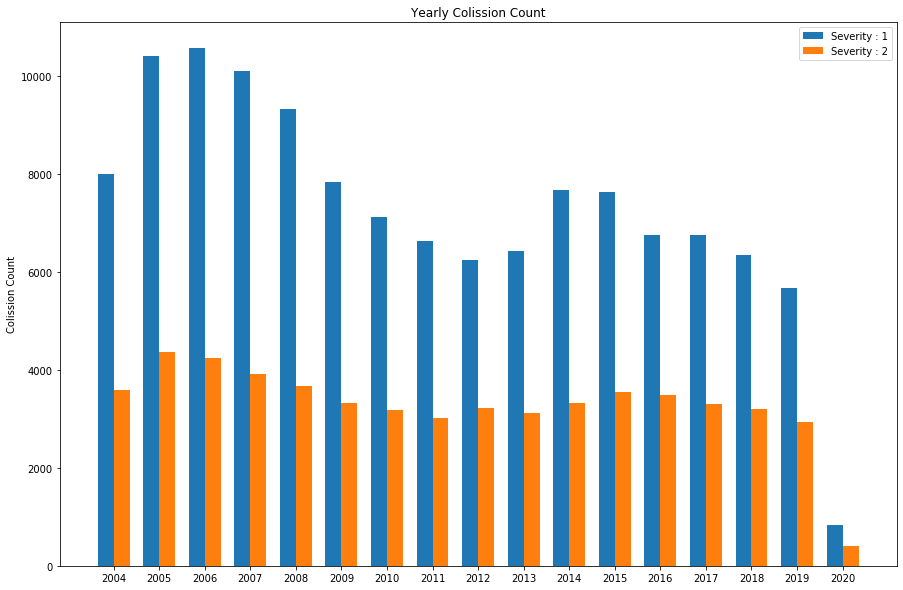

In [43]:
years = yearlydf.index.values
x = np.arange(len(years))
width = 0.35
ax = plt.figure(figsize = (15,10)).add_subplot(111)
cat1 = ax.bar(x - width/2, yearlydf[1], width, label = 'Severity : 1')
cat2 = ax.bar(x + width/2, yearlydf[2], width, label = 'Severity : 2')

ax.set_ylabel('Colission Count')
ax.set_title('Yearly Colission Count')
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()


<h3> Insights from the above Plot </h3>

It is clear that there is no direct relationship on year with severity as the variation in number of colissions of both severity varies randomly with year. In essence there is no impact of a particular year on the severity. This makes general sense as the severity of a colission, logically, would not have any effect by which year it is. However we do see that 2020 has far fewer colissions. This is attributed to 2 factors:

- The United States is a hotspot of the ongoing **COVID-19** Pandemic which has forced many states into lockdown and many individuals are opting to work from home, shop online and reduce outside activities. Hence this has caused the number of colissions to drop.
- The year 2020 is still not over.

Plotting the colissions for a particular month

In [44]:
months = ['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec']
monthlydf = make_countdf(col_name = 'MONTH', df = dfcombined, indexlist = months)
display(monthlydf.style.background_gradient(cmap = 'Reds',axis = 0))

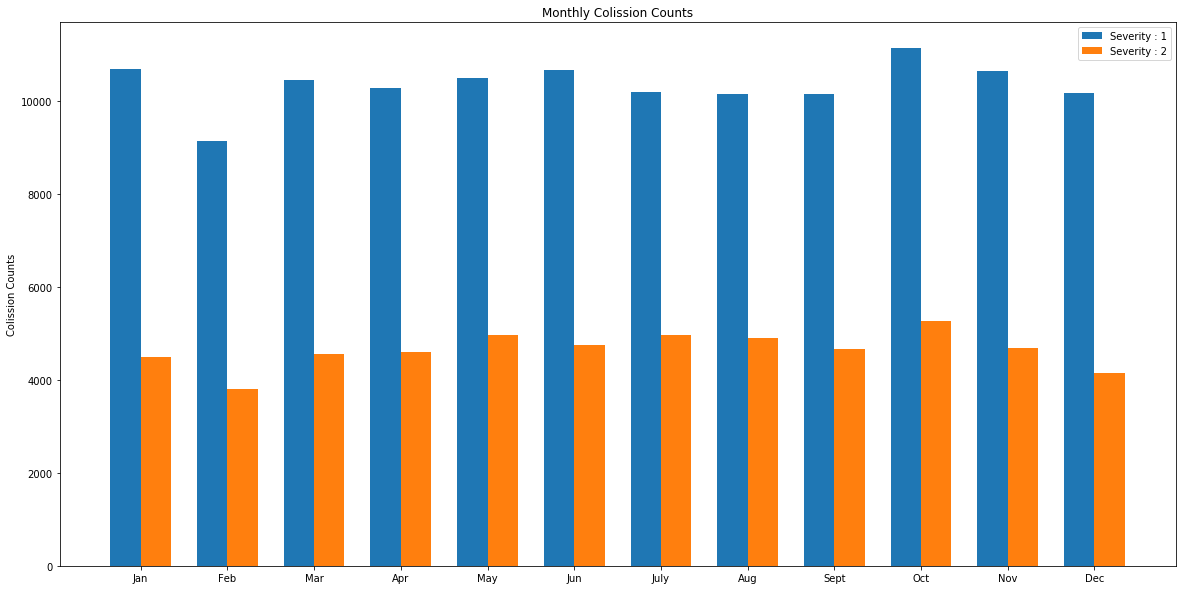

In [45]:
x_months = np.arange(len(months))
width = 0.35
ax1 = plt.figure(figsize = (20,10)).add_subplot(111)
sev1 = ax1.bar(x_months - (width/2), monthlydf[1],width, label = 'Severity : 1')
sev2 = ax1.bar(x_months + (width/2), monthlydf[2],width, label = 'Severity : 2')


ax1.set_title('Monthly Colission Counts')
ax1.set_ylabel('Colission Counts')
ax1.set_xticks(x_months)
ax1.set_xticklabels(months)
ax1.legend()


<h3> Insights from the above Plot </h3>

It is clear from the above plots that there is no significant variation among the months when it comes to either Severity Code and Number of colissions.  

Plotting colissions for a particular day of week

In [46]:
day_of_week = ['Mon','Tue','Wed','Thur','Fri','Sat','Sun']
dailydf = make_countdf(col_name = 'DAY', df = dfcombined, indexlist = day_of_week)
display(dailydf.style.background_gradient(cmap = 'Reds',axis = 0))

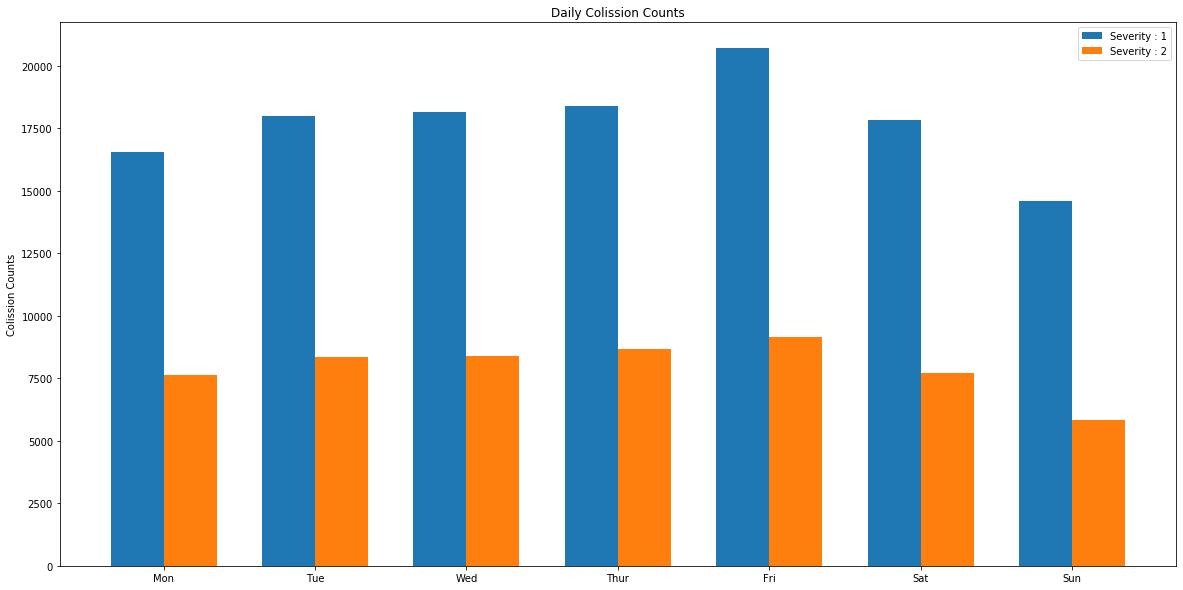

In [47]:
days = np.arange(len(day_of_week))
width = 0.35
ax2 = plt.figure(figsize = (20,10)).add_subplot(111)
sev1_day = ax2.bar(days - (width/2), dailydf[1], width, label = 'Severity : 1')
sev2_day = ax2.bar(days + (width/2), dailydf[2], width, label = 'Severity : 2')

ax2.set_title('Daily Colission Counts')
ax2.set_ylabel('Colission Counts')
ax2.set_xticks(days)
ax2.set_xticklabels(day_of_week)
ax2.legend()

From the above Daily Colission plot and the preceding plots with respect to Yearly and Monthly colissions, there is no significant impact on these 3 attributes on the colission. Hence we can dismiss these three attributes from the predictive model. 


In [48]:
#drop YEAR, MONTH, DAY
dfcombined_ver2 = dfcombined_original.drop(['YEAR','MONTH','DAY'],axis = 1)
dfcombined_ver2.head()

X          Y      ADDRTYPE                    SEVERITYDESC  \
0 -122.323148  47.703140  Intersection                Injury Collision   
1 -122.347294  47.647172         Block  Property Damage Only Collision   
2 -122.334540  47.607871         Block  Property Damage Only Collision   
3 -122.334803  47.604803         Block  Property Damage Only Collision   
4 -122.306426  47.545739  Intersection                Injury Collision   

  COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
0        Angles            2         0            0         2   
1     Sideswipe            2         0            0         2   
2    Parked Car            4         0            0         3   
3         Other            3         0            0         3   
4        Angles            2         0            0         2   

                              JUNCTIONTYPE  SDOT_COLCODE UNDERINFL   WEATHER  \
0   At Intersection (intersection related)            11         0  Overcast   
1  Mid-Block (not related to intersection)            16         0   Raining   
2  Mid-Block (not related to intersection)            14         0  Overcast   
3  Mid-Block (not related to intersection)            11         0     Clear   
4   At Intersection (intersection related)            11         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING ST_COLCODE  SEGLANEKEY  \
0      Wet                 Daylight         0         10           0   
1      Wet  Dark - Street Lights On         0         11           0   
2      Dry                 Daylight         0         32           0   
3      Dry                 Daylight         0         23           0   
4      Wet                 Daylight         0         10           0   

   CROSSWALKKEY  HITPARKEDCAR TIMEOFDAY  SEVERITYCODE  
0             0             0      Noon             2  
1             0             0   Evening             1  
2             0             0   Morning             1  
3             0             0   Morning             1  
4             0             0   Morning             2

<h2>Given how traffic varies depending on time of day, we hall investigate further into the **TIMEOFDAY** attribute</h2>

In [49]:
timeofdaydf = make_countdf(col_name = 'TIMEOFDAY', df = dfcombined_ver2)
display(timeofdaydf.style.background_gradient(cmap = 'Reds',axis = 0))

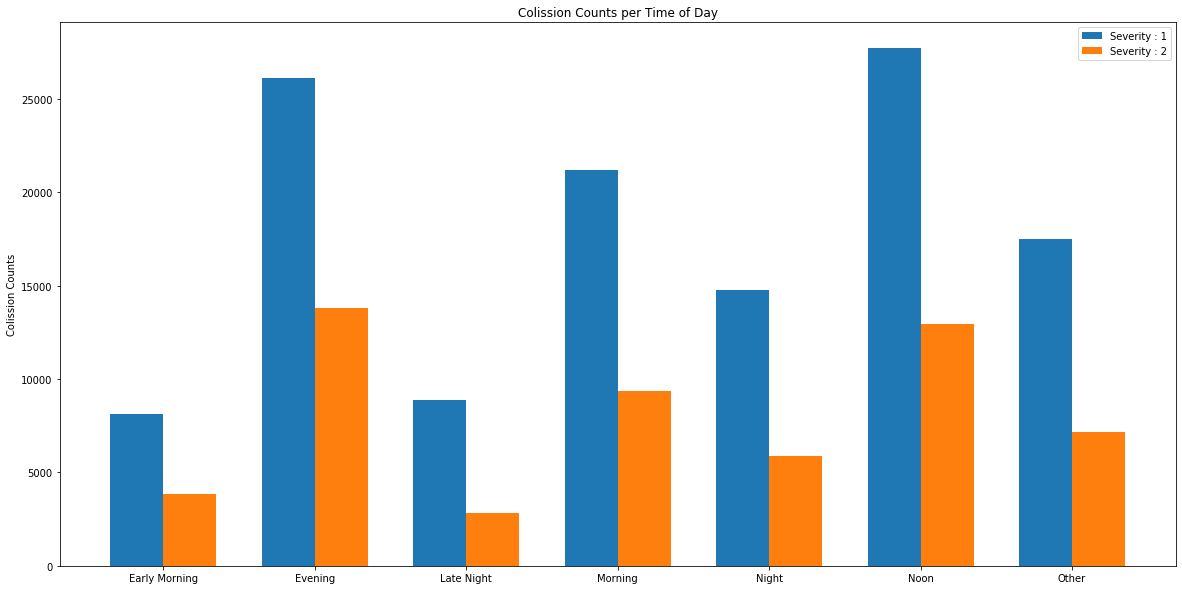

In [50]:
time_of_day = np.arange(len(dfcombined_ver2['TIMEOFDAY'].unique().tolist()))
width = 0.35
ax3 = plt.figure(figsize = (20,10)).add_subplot(111)
sev1_time = ax3.bar(time_of_day - (width/2), timeofdaydf[1], width, label = 'Severity : 1')
sev2_time = ax3.bar(time_of_day + (width/2), timeofdaydf[2], width, label = 'Severity : 2')

ax3.set_title('Colission Counts per Time of Day')
ax3.set_ylabel('Colission Counts')
ax3.set_xticks(time_of_day)
ax3.set_xticklabels(timeofdaydf.index.values)
ax3.legend()

From the above visualization, it seems that Evening, Morning, Noon and Other categories tend to have more collisions.

To investigate the relationship between the categorical variables and the severity which is a binary value (1 and 2), we cannot use the ANOVA method as there is no normal distribution among the severity. Instead we shall use the Chi Squared Test. 

In [51]:
temptable = timeofdaydf.transpose()
contingencytable = temptable.to_numpy()

In [52]:
#we produce a contingency table to be given to the Scipy Chi2_contingency method
contingencytable

array([[ 8108., 26116.,  8894., 21168., 14761., 27717., 17494.],
       [ 3818., 13828.,  2816.,  9381.,  5856., 12940.,  7170.]])

In [53]:
from scipy.stats import chi2_contingency
chi2val,p,dof,expected = chi2_contingency(contingencytable)

In [54]:
p

2.401041385982495e-134

<h3>Investigate the ADDRTYPE and how it correlates with the Severity of Colission</h3>

In [55]:
addrtypedf = make_countdf(col_name = 'ADDRTYPE',df = dfcombined_ver2)
display(addrtypedf.style.background_gradient(cmap = 'Reds', axis = 0))

<h3>Investigate the SEVERITYDESC and how it correlates with the Severity of Colission</h3>


In [56]:
sevdescdf = make_countdf(col_name = 'SEVERITYDESC',df = dfcombined_ver2)
display(sevdescdf.style.background_gradient(cmap = 'Reds', axis = 0))

Creating a count dateframe of the ADDRTYPE as above shows that SEVERITYDESC should not be considered as an attribute as it is a direct description of the SEVERITY CODE OF COLISSION. Hence we shall drop it from the dataset

In [57]:
#drop YEAR, MONTH, DAY, ADDRTYPE
dfcombined_ver3 = dfcombined_original.drop(['YEAR','MONTH','DAY','SEVERITYDESC'],axis = 1)
dfcombined_ver3.head()

X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0 -122.323148  47.703140  Intersection        Angles            2         0   
1 -122.347294  47.647172         Block     Sideswipe            2         0   
2 -122.334540  47.607871         Block    Parked Car            4         0   
3 -122.334803  47.604803         Block         Other            3         0   
4 -122.306426  47.545739  Intersection        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                             JUNCTIONTYPE  \
0            0         2   At Intersection (intersection related)   
1            0         2  Mid-Block (not related to intersection)   
2            0         3  Mid-Block (not related to intersection)   
3            0         3  Mid-Block (not related to intersection)   
4            0         2   At Intersection (intersection related)   

   SDOT_COLCODE UNDERINFL   WEATHER ROADCOND                LIGHTCOND  \
0            11         0  Overcast      Wet                 Daylight   
1            16         0   Raining      Wet  Dark - Street Lights On   
2            14         0  Overcast      Dry                 Daylight   
3            11         0     Clear      Dry                 Daylight   
4            11         0   Raining      Wet                 Daylight   

   SPEEDING ST_COLCODE  SEGLANEKEY  CROSSWALKKEY  HITPARKEDCAR TIMEOFDAY  \
0         0         10           0             0             0      Noon   
1         0         11           0             0             0   Evening   
2         0         32           0             0             0   Morning   
3         0         23           0             0             0   Morning   
4         0         10           0             0             0   Morning   

   SEVERITYCODE  
0             2  
1             1  
2             1  
3             1  
4             2

<h3> SEGLANEKEY and CROSSWALKKEY </h3>

In [58]:
pd.crosstab(dfcombined_ver3['SEVERITYCODE'],dfcombined_ver3['CROSSWALKKEY'])

CROSSWALKKEY  0        523      7358     9073     10590    15485    17558    \
SEVERITYCODE                                                                  
1              123850        0        0        0        0        0        1   
2               52483        1        1        1        1        1        0   

CROSSWALKKEY  21214    23860    23878    23883    24029    24099    24165    \
SEVERITYCODE                                                                  
1                   1        1        0        0        0        0        0   
2                   0        0        1        1        1        1        1   

CROSSWALKKEY  24267    24281    24377    24378    24409    24428    24450    \
SEVERITYCODE                                                                  
1                   0        0        1        0        0        0        0   
2                   1        1        0        1        1        1        1   

CROSSWALKKEY  24490    24533    24653    24855    ...  642048   642408   \
SEVERITYCODE                                      ...                     
1                   1        1        0        1  ...        0        0   
2                   0        0        1        0  ...        1        1   

CROSSWALKKEY  642420   664365   664366   664953   668165   678782   696052   \
SEVERITYCODE                                                                  
1                   0        0        0        0        0        0        0   
2                   1        1        1        1        1        1        1   

CROSSWALKKEY  699680   699687   699720   699723   699736   699738   699876   \
SEVERITYCODE                                                                  
1                   0        0        0        0        0        0        0   
2                   1        1        1        1        1        1        1   

CROSSWALKKEY  699879   699889   700388   700526   701110   701280   701306   \
SEVERITYCODE                                                                  
1                   0        0        0        0        0        0        0   
2                   1        1        1        1        1        1        1   

CROSSWALKKEY  703480   5239700  
SEVERITYCODE                    
1                   0        0  
2                   1        1  

[2 rows x 2169 columns]

In [59]:
pd.crosstab(dfcombined_ver3['SEVERITYCODE'],dfcombined_ver3['SEGLANEKEY'])

SEGLANEKEY    0       1189    1200    1248    1257    1271    1309    1350    \
SEVERITYCODE                                                                   
1             123959       0       0       0       0       1       1       0   
2              53409       1       1       1       1       0       0       1   

SEGLANEKEY    1371    1408    1414    1499    1506    1550    1627    1793    \
SEVERITYCODE                                                                   
1                  0       1       0       0       0       0       0       0   
2                  1       0       1       1       1       1       1       1   

SEGLANEKEY    1824    1873    1876    1884    1893    1961    2052    2105    \
SEVERITYCODE                                                                   
1                  0       0       0       0       0       0       1       1   
2                  1       1       1       1       1       1       0       1   

SEGLANEKEY    2112    ...  44420   44421   44559   44781   44997   45283   \
SEVERITYCODE          ...                                                   
1                  1  ...       0       0       0       0       1       0   
2                  1  ...       1       2       1       1       0       1   

SEGLANEKEY    45335   45465   45488   45509   45514   45532   45540   45553   \
SEVERITYCODE                                                                   
1                  0       1       0       0       0       0       2       0   
2                  1       0       4       2       2       4       0       1   

SEGLANEKEY    45557   45748   45800   45831   45832   46981   54728   59260   \
SEVERITYCODE                                                                   
1                  0       0       0       0       0       0       0       0   
2                  1       1       1       1       1       1       1       1   

SEGLANEKEY    521117  525169  525241  
SEVERITYCODE                          
1                  0       0       0  
2                  1       1       1  

[2 rows x 1919 columns]

Other than the initial Lane Key of 0 in both CROSSWALKEY and SEGLANEKEY, other Keys occur with very low frequency. Hence we can call these as "Others"

In [60]:
dfcombined_ver3.loc[dfcombined_ver3['CROSSWALKKEY'] != 0, 'CROSSWALKKEY'] = 'Others'
dfcombined_ver3.loc[dfcombined_ver3['SEGLANEKEY'] != 0, 'SEGLANEKEY'] = 'Others'
dfcombined_ver3.loc[dfcombined_ver3['CROSSWALKKEY'] == 0, 'CROSSWALKKEY'] = 'Lane1'
dfcombined_ver3.loc[dfcombined_ver3['SEGLANEKEY'] == 0, 'SEGLANEKEY'] = 'Lane1'

In [61]:
pd.crosstab(dfcombined_ver3['SEVERITYCODE'],dfcombined_ver3['SEGLANEKEY'])

SEGLANEKEY     Lane1  Others
SEVERITYCODE                
1             123959     299
2              53409    2400

In [62]:
pd.crosstab(dfcombined_ver3['SEVERITYCODE'],dfcombined_ver3['CROSSWALKKEY'])

CROSSWALKKEY   Lane1  Others
SEVERITYCODE                
1             123850     408
2              52483    3326

In [63]:
#dfcombined_ver3.drop(['ST_COLCODE','SDOT_COLCODE'],axis = 1, inplace = True)
#its easier to deal with an categorical variable than dealing with an integer code. Hence the SDOT_COLCODE and 
#As sdot_colcodefinal and st_colcodefinal are Style Objects, we need to make them to Dataframes
sdot_colcodefinaldf = sdot_colcodefinal.data
st_colcodefinaldf = st_colcodefinal.data
for (code,desc) in zip(sdot_colcodefinaldf['SDOT_COLCODE'],sdot_colcodefinaldf['SDOT_COLDESC']):
    dfcombined_ver3.loc[dfcombined_ver3['SDOT_COLCODE'] == code, 'SDOT_COLCODE'] = desc
for (code,desc) in zip(st_colcodefinaldf['ST_COLCODE'],st_colcodefinaldf['ST_COLDESC']):
    dfcombined_ver3.loc[dfcombined_ver3['ST_COLCODE'] == code, 'ST_COLCODE'] = desc
dfcombined_ver3.head()

X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0 -122.323148  47.703140  Intersection        Angles            2         0   
1 -122.347294  47.647172         Block     Sideswipe            2         0   
2 -122.334540  47.607871         Block    Parked Car            4         0   
3 -122.334803  47.604803         Block         Other            3         0   
4 -122.306426  47.545739  Intersection        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                             JUNCTIONTYPE  \
0            0         2   At Intersection (intersection related)   
1            0         2  Mid-Block (not related to intersection)   
2            0         3  Mid-Block (not related to intersection)   
3            0         3  Mid-Block (not related to intersection)   
4            0         2   At Intersection (intersection related)   

                                        SDOT_COLCODE UNDERINFL   WEATHER  \
0  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0  Overcast   
1  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...         0   Raining   
2       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0  Overcast   
3  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0     Clear   
4  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING  \
0      Wet                 Daylight         0   
1      Wet  Dark - Street Lights On         0   
2      Dry                 Daylight         0   
3      Dry                 Daylight         0   
4      Wet                 Daylight         0   

                                          ST_COLCODE SEGLANEKEY CROSSWALKKEY  \
0                                  Entering at angle      Lane1        Lane1   
1  From same direction - both going straight - bo...      Lane1        Lane1   
2                             One parked--one moving      Lane1        Lane1   
3                   From same direction - all others      Lane1        Lane1   
4                                  Entering at angle      Lane1        Lane1   

   HITPARKEDCAR TIMEOFDAY  SEVERITYCODE  
0             0      Noon             2  
1             0   Evening             1  
2             0   Morning             1  
3             0   Morning             1  
4             0   Morning             2

In [64]:
sdotcolcodecountdf = pd.crosstab(dfcombined_ver3['SDOT_COLCODE'],dfcombined_ver3['SEVERITYCODE'])
sdotcolcodecountdf['Total'] = sdotcolcodecountdf[1] + sdotcolcodecountdf[2]
sdotcolcodecountdf
#getting the SDOT COL CODES with lower than 1000 instances in total of both severity levels


SEVERITYCODE                                            1      2  Total
SDOT_COLCODE                                                           
DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT     94     11    105
DRIVERLESS VEHICLE RAN OFF ROAD - NO COLLISION          1      0      1
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE FRONT E...     94      7    101
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SI...     51      2     53
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SI...      3      1      4
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END       81      9     90
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT S...     11      1     12
DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT S...      5      1      6
DRIVERLESS VEHICLE STRUCK OBJECT IN ROADWAY             3      0      3
DRIVERLESS VEHICLE STRUCK PEDESTRIAN                    0      8      8
MOTOR VEHCILE STRUCK PEDESTRIAN                       638   5702   6340
MOTOR VEHICLE OVERTURNED IN ROAD                      112    345    457
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT        6303   2179   8482
MOTOR VEHICLE RAN OFF ROAD - NO COLLISION             124     35    159
MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END A...  58588  23827  82415
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE A...   5392    197   5589
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE S...   8970    665   9635
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END        34553  16933  51486
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE ...   1338     27   1365
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE ...   1487     73   1560
MOTOR VEHICLE STRUCK OBJECT IN ROAD                  2983    974   3957
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT...    344   2665   3009
MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE SI...     31     89    120
MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END            40    140    180
MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE S...      1     14     15
MOTOR VEHICLE STRUCK TRAIN                             82     19    101
NOT ENOUGH INFORMATION / NOT APPLICABLE              2714    272   2986
PEDALCYCLIST OVERTURNED IN ROAD                         1     66     67
PEDALCYCLIST RAN OFF ROAD - HIT FIXED OBJECT            1      3      4
PEDALCYCLIST STRUCK MOTOR VEHICLE FRONT END AT ...    147   1134   1281
PEDALCYCLIST STRUCK MOTOR VEHICLE LEFT SIDE AT ...      2      7      9
PEDALCYCLIST STRUCK MOTOR VEHICLE LEFT SIDE SID...     19    156    175
PEDALCYCLIST STRUCK MOTOR VEHICLE REAR END             30    102    132
PEDALCYCLIST STRUCK MOTOR VEHICLE RIGHT SIDE AT...      1      1      2
PEDALCYCLIST STRUCK MOTOR VEHICLE RIGHT SIDE SI...     10     40     50
PEDALCYCLIST STRUCK OBJECT IN ROAD                      1     22     23
PEDALCYCLIST STRUCK PEDALCYCLIST FRONT END AT A...      0      4      4
PEDALCYCLIST STRUCK PEDALCYCLIST REAR END               0      7      7
PEDALCYCLIST STRUCK PEDESTRIAN                          3     71     74

In [65]:
sdotcodes_below1000 = sdotcolcodecountdf[sdotcolcodecountdf['Total'] < 1500].index
sdotcodes_below1000.tolist()

['DRIVERLESS VEHICLE RAN OFF ROAD - HIT FIXED OBJECT',
 'DRIVERLESS VEHICLE RAN OFF ROAD - NO COLLISION',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE FRONT END AT ANGLE',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE AT ANGLE',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE LEFT SIDE SIDESWIPE',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE REAR END',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE AT ANGLE ',
 'DRIVERLESS VEHICLE STRUCK MOTOR VEHICLE RIGHT SIDE SIDESWIPE',
 'DRIVERLESS VEHICLE STRUCK OBJECT IN ROADWAY',
 'DRIVERLESS VEHICLE STRUCK PEDESTRIAN',
 'MOTOR VEHICLE OVERTURNED IN ROAD',
 'MOTOR VEHICLE RAN OFF ROAD - NO COLLISION',
 'MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE AT ANGLE',
 'MOTOR VEHICLE STRUCK PEDALCYCLIST, LEFT SIDE SIDESWIPE',
 'MOTOR VEHICLE STRUCK PEDALCYCLIST, REAR END',
 'MOTOR VEHICLE STRUCK PEDALCYCLIST, RIGHT SIDE SIDESWIPE',
 'MOTOR VEHICLE STRUCK TRAIN',
 'PEDALCYCLIST OVERTURNED IN ROAD',
 'PEDALCYCLIST RAN OFF ROAD - HIT FIXED OBJECT',
 'PEDA

Given that SDOT_COLCODE has a lot of categories with little instances occuring in the data set, we club these into one category of others. This gives us 2 advantages:

- Easier to one hot encode as we will have only categories with significant occurences. Given that SDOT_COLCODE has a large amount of codes, with a significant amount of them having less than 1500 instances in total, it is better to put these categories into 1 called 'Other'
- It gives us a accurate feature relationship metric (Chi Squared Score in this case) when we have less categories, as having a large number of categories will result in a large value as a result of the category. However this is not accurate. 

<h4> This same approach will be applied to ST_COLCODE too </h4>

In [66]:
for code in sdotcodes_below1000:
    dfcombined_ver3.loc[(dfcombined_ver3['SDOT_COLCODE'] == code),'SDOT_COLCODE'] = 'Other'
dfcombined_ver3.head()

X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  PEDCOUNT  \
0 -122.323148  47.703140  Intersection        Angles            2         0   
1 -122.347294  47.647172         Block     Sideswipe            2         0   
2 -122.334540  47.607871         Block    Parked Car            4         0   
3 -122.334803  47.604803         Block         Other            3         0   
4 -122.306426  47.545739  Intersection        Angles            2         0   

   PEDCYLCOUNT  VEHCOUNT                             JUNCTIONTYPE  \
0            0         2   At Intersection (intersection related)   
1            0         2  Mid-Block (not related to intersection)   
2            0         3  Mid-Block (not related to intersection)   
3            0         3  Mid-Block (not related to intersection)   
4            0         2   At Intersection (intersection related)   

                                        SDOT_COLCODE UNDERINFL   WEATHER  \
0  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0  Overcast   
1  MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...         0   Raining   
2       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0  Overcast   
3  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0     Clear   
4  MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0   Raining   

  ROADCOND                LIGHTCOND  SPEEDING  \
0      Wet                 Daylight         0   
1      Wet  Dark - Street Lights On         0   
2      Dry                 Daylight         0   
3      Dry                 Daylight         0   
4      Wet                 Daylight         0   

                                          ST_COLCODE SEGLANEKEY CROSSWALKKEY  \
0                                  Entering at angle      Lane1        Lane1   
1  From same direction - both going straight - bo...      Lane1        Lane1   
2                             One parked--one moving      Lane1        Lane1   
3                   From same direction - all others      Lane1        Lane1   
4                                  Entering at angle      Lane1        Lane1   

   HITPARKEDCAR TIMEOFDAY  SEVERITYCODE  
0             0      Noon             2  
1             0   Evening             1  
2             0   Morning             1  
3             0   Morning             1  
4             0   Morning             2

In [67]:
pd.crosstab(dfcombined_ver3['SDOT_COLCODE'],dfcombined_ver3['SEVERITYCODE'])

SEVERITYCODE                                            1      2
SDOT_COLCODE                                                    
MOTOR VEHCILE STRUCK PEDESTRIAN                       638   5702
MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT        6303   2179
MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END A...  58588  23827
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE A...   5392    197
MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE S...   8970    665
MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END        34553  16933
MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE ...   1487     73
MOTOR VEHICLE STRUCK OBJECT IN ROAD                  2983    974
MOTOR VEHICLE STRUCK PEDALCYCLIST, FRONT END AT...    344   2665
NOT ENOUGH INFORMATION / NOT APPLICABLE              2714    272
Other                                                2286   2322

In [68]:
stcolcodecountdf = pd.crosstab(dfcombined_ver3['ST_COLCODE'],dfcombined_ver3['SEVERITYCODE'])
stcolcodecountdf['Total'] = stcolcodecountdf[1] + stcolcodecountdf[2]
stcolcodecountdf

SEVERITYCODE                                            1      2  Total
ST_COLCODE                                                             
All Other Multi Vehicle                                 5      3      8
All other non-collision                                70     31    101
Breakage of any part of the vehicle resulting i...     21      9     30
Domestic animal other (cat, dog, etc)                  29      2     31
Entering at angle                                   20811  13542  34353
Fire started in vehicle                                 6      1      7
Fixed object                                         9158   2999  12157
From opposite direction - all others                  830    442   1272
From opposite direction - both going straight -...    172     52    224
From opposite direction - both going straight -...    734    276   1010
From opposite direction - both moving - head-on       213    363    576
From opposite direction - one left turn - one r...    234     49    283
From opposite direction - one left turn - one s...   5645   4599  10244
From opposite direction - one stopped - head-on        80     51    131
From same direction - all others                     3527    796   4323
From same direction - both going straight - bot...   4297   2882   7179
From same direction - both going straight - bot...  10495   1683  12178
From same direction - both going straight - one...  13884  11041  24925
From same direction - both going straight - one...   2124    241   2365
From same direction - one left turn - one straight   2334    725   3059
From same direction - one right turn - one stra...   2302    599   2901
Non-domestic animal (deer, bear, elk, etc)              0      1      1
Not stated                                             27     10     37
One car entering driveway access                     1049    545   1594
One car entering parked position                      629     74    703
One car leaving driveway access                      1613    607   2220
One car leaving parked position                      2341    434   2775
One parked--one moving                              37292   2116  39408
Other object                                          266     63    329
Pedalcyclist All Other Involvements ONE UNIT - ...      2     21     23
...                                                   ...    ...    ...
Person fell, jumped or was pushed from vehicle          4     20     24
Railway Vehicle Strikes Pedalcyclist                    2      0      2
Railway Vehicle Strikes Pedestrian                      9      2     11
Railway Vehicle Strikes Vehicle                        82     21    103
Same direction -- both turning left -- both mov...     64     21     85
Same direction -- both turning left -- both mov...    749     68    817
Same direction -- both turning left -- one stop...     62     32     94
Same direction -- both turning left -- one stop...     32      2     34
Same direction -- both turning right -- both mo...    107     54    161
Same direction -- both turning right -- both mo...   1078     85   1163
Same direction -- both turning right -- one sto...    198    136    334
Same direction -- both turning right -- one sto...     63      8     71
Strikes or Was Struck by Object from the Load o...      7      2      9
Strikes or Was Struck by a Part of Another Vehi...      4      0      4
Vehicle - Pedalcyclist                                565   4061   4626
Vehicle Hits City Road or Construction Machinery       40      7     47
Vehicle Hits Other Road or Construction Machinery       6      4     10
Vehicle Hits State Road or Construction Machinery       1      0      1
Vehicle Strikes All Other Non-Domestic Animal           0      2      2
Vehicle Strikes Deer                                    1      0      1
Vehicle Strikes Pedalcyclist                           59    351    410
Vehicle Strikes Railway Vehicle                        42     13     55
Vehicle Struck by City Road or Construct

In [69]:
stcodes_below1000 = stcolcodecountdf[stcolcodecountdf['Total'] < 1500].index
stcodes_below1000.tolist()

['All Other Multi Vehicle',
 'All other non-collision',
 'Breakage of any part of the vehicle resulting in injury or in further property damage',
 'Domestic animal other (cat, dog, etc)',
 'Fire started in vehicle',
 'From opposite direction - all others',
 'From opposite direction - both going straight - one stopped - sideswipe',
 'From opposite direction - both going straight - sideswipe',
 'From opposite direction - both moving - head-on',
 'From opposite direction - one left turn - one right turn',
 'From opposite direction - one stopped - head-on',
 'Non-domestic animal (deer, bear, elk, etc)',
 'Not stated',
 'One car entering parked position',
 'Other object',
 'Pedalcyclist All Other Involvements ONE UNIT - PEDALCYCLIST ONLY or PEDALCYCLIST STR',
 'Pedalcyclist Strikes Moving Vehicle',
 'Pedalcyclist Strikes Pedalcyclist or Pedestrian',
 'Person fell, jumped or was pushed from vehicle',
 'Railway Vehicle Strikes Pedalcyclist',
 'Railway Vehicle Strikes Pedestrian',
 'Railway Ve

In [70]:
for code in stcodes_below1000:
    dfcombined_ver3.loc[(dfcombined_ver3['ST_COLCODE'] == code),'ST_COLCODE'] = 'Other'
pd.crosstab(dfcombined_ver3['ST_COLCODE'],dfcombined_ver3['SEVERITYCODE'])

SEVERITYCODE                                            1      2
ST_COLCODE                                                      
Entering at angle                                   20811  13542
Fixed object                                         9158   2999
From opposite direction - one left turn - one s...   5645   4599
From same direction - all others                     3527    796
From same direction - both going straight - bot...   4297   2882
From same direction - both going straight - bot...  10495   1683
From same direction - both going straight - one...  13884  11041
From same direction - both going straight - one...   2124    241
From same direction - one left turn - one straight   2334    725
From same direction - one right turn - one stra...   2302    599
One car entering driveway access                     1049    545
One car leaving driveway access                      1613    607
One car leaving parked position                      2341    434
One parked--one moving                              37292   2116
Other                                                6341   4453
Vehicle - Pedalcyclist                                565   4061
Vehicle going straight hits pedestrian                303   2498
Vehicle turning left hits pedestrian                  177   1988

<h2>Splitting the data into a Train Set and a Test Set</h2>

In order to maintain the ratio of Severity Code within both Train and Test sets o ensure both sets are representative of the data, Stratified Splitting is used.

In [71]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter =  StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in splitter.split(dfcombined_ver3, dfcombined_ver3['SEVERITYCODE']):
    strat_train_set = dfcombined_ver3.loc[train_index]
    strat_test_set  = dfcombined_ver3.loc[test_index]

In [72]:
strat_train_set['SEVERITYCODE'].value_counts(normalize = True)

1    0.690065
2    0.309935
Name: SEVERITYCODE, dtype: float64

In [73]:
strat_test_set['SEVERITYCODE'].value_counts(normalize = True)

1    0.690065
2    0.309935
Name: SEVERITYCODE, dtype: float64

In [74]:
dfcombined_ver3['SEVERITYCODE'].value_counts(normalize = True)

1    0.690065
2    0.309935
Name: SEVERITYCODE, dtype: float64

As observed from the above **value_counts** results, the strat_train_set and strat_test_set are representative of all the data in dfcombined_ver3 as the ratio of SEVERITYCODE is maintained

In [75]:
#make a copy of the train_set and DONT touch the test_set 
dftraining = strat_train_set.copy()
dftraining.head()


X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  \
157437 -122.315789  47.664923         Block    Rear Ended            0   
134015 -122.344947  47.720482         Block       Head On            2   
168699 -122.339357  47.609781         Block    Rear Ended            2   
156901 -122.315518  47.613354  Intersection         Other            2   
40099  -122.263691  47.682926  Intersection     Sideswipe            4   

        PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
157437         0            0         3   
134015         0            0         2   
168699         0            0         2   
156901         0            0         1   
40099          0            0         2   

                                   JUNCTIONTYPE  \
157437  Mid-Block (not related to intersection)   
134015  Mid-Block (not related to intersection)   
168699     Mid-Block (but intersection related)   
156901   At Intersection (intersection related)   
40099    At Intersection (intersection related)   

                                             SDOT_COLCODE UNDERINFL   WEATHER  \
157437       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0  Overcast   
134015       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0     Clear   
168699       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0     Clear   
156901      MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT         0     Clear   
40099   MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0  Overcast   

       ROADCOND                LIGHTCOND  SPEEDING  \
157437      Dry  Dark - Street Lights On         0   
134015      Dry  Dark - Street Lights On         0   
168699      Dry                 Daylight         0   
156901      Dry  Dark - Street Lights On         0   
40099       Dry                 Daylight         0   

                                               ST_COLCODE SEGLANEKEY  \
157437  From same direction - both going straight - on...      Lane1   
134015                                              Other      Lane1   
168699  From same direction - both going straight - on...      Lane1   
156901                                       Fixed object      Lane1   
40099                                               Other      Lane1   

       CROSSWALKKEY  HITPARKEDCAR   TIMEOFDAY  SEVERITYCODE  
157437        Lane1             0  Late Night             1  
134015        Lane1             0       Night             1  
168699        Lane1             0     Evening             1  
156901        Lane1             0       Night             2  
40099         Lane1             0       Other             1

In [76]:
dftrainingfeatures = dftraining.iloc[:,:-1]
severitylabel = dftraining.iloc[:,-1]

<h4> Create a new class prep_df to be used with a Pipeline for extracting the required attributes</h4>

In [77]:
from sklearn.base import BaseEstimator,TransformerMixin

class prep_df(BaseEstimator, TransformerMixin):
    def __init__(self, attribs):
        self.attribute_names = attribs
    def fit(self,X):
        return self
    def transform(self,X):
        return X[self.attribute_names].values
    


<h4> This pipeline allows to extract the required categorical features and encode them using Ordinal Encoder</h4>

In [78]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
cat_attribs = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE','SDOT_COLCODE','WEATHER','ROADCOND','LIGHTCOND',
              'ST_COLCODE','SPEEDING','UNDERINFL','SEGLANEKEY','CROSSWALKKEY','HITPARKEDCAR','TIMEOFDAY']
cat_pipeline = Pipeline(steps = [
                        ('select_cat_attribs',prep_df(cat_attribs)),
                        ('oe',OrdinalEncoder()),
                        ])

In [79]:
dffeatures_cat = cat_pipeline.fit_transform(dftrainingfeatures)
dffeatures_cat

array([[0., 7., 4., ..., 0., 0., 2.],
       [0., 2., 4., ..., 0., 0., 4.],
       [0., 7., 3., ..., 0., 0., 1.],
       ...,
       [0., 6., 3., ..., 0., 0., 4.],
       [0., 9., 3., ..., 0., 0., 6.],
       [1., 1., 1., ..., 0., 0., 3.]])

In [80]:
dffeatures_cat[:,-3].max()

1.0

<h4> We need to investigate which features have a relationship with the Severity Label and which are independent. As these are categorical variables and the Severity Label is also a categorical attribute, we cannot use the ANOVA test to calculate the FScore as there is no normal distribution among the Severity Label (it is a binary attribute and not contiuous). Hence we calculate the Chi Squared value using the Chi Squared Test which calculates how different the Expected Frequency and Observed Frequency is. If the difference is large the Chi Squared Value is large and there is a relationship between variable and Severity Label </h4>

In [81]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#encoded severity labels
testlabels = le.fit_transform(severitylabel)

fs = SelectKBest(score_func = chi2,k = 'all')
fs.fit(dffeatures_cat,testlabels)
for (i,attribute) in enumerate(cat_attribs):
    print(attribute , ':' , fs.scores_[i])

ADDRTYPE : 3578.5623289567266
COLLISIONTYPE : 4276.478396802961
JUNCTIONTYPE : 4204.780024372779
SDOT_COLCODE : 0.0016103566975164457
WEATHER : 177.76840996485612
ROADCOND : 654.9585515813676
LIGHTCOND : 15.78748579959931
ST_COLCODE : 2500.789544046166
SPEEDING : 183.89113641524474
UNDERINFL : 233.18661578447578
SEGLANEKEY : 3396.0701981680977
CROSSWALKKEY : 4709.971841109633
HITPARKEDCAR : 1208.4779914671326
TIMEOFDAY : 97.18745877662526


In [82]:
pd.crosstab(dftraining['SEVERITYCODE'],dftraining['SPEEDING'])

SPEEDING          0     1
SEVERITYCODE             
1             95142  4264
2             41975  2672

<h4>Now we shall turn our attention to the continuous variables to find their feature importance</h4>

In [83]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = dftrainingfeatures[['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']]
scaler.fit(X)
scaledresult = scaler.fit_transform(X)
scaledresult

array([[ 0.49043601,  0.80473866, -1.82060561, -0.19218818, -0.17536986,
         1.83188519],
       [-0.4820715 ,  1.79095974, -0.35210628, -0.19218818, -0.17536986,
         0.04734719],
       [-0.29563604, -0.1740715 , -0.35210628, -0.19218818, -0.17536986,
         0.04734719],
       ...,
       [-0.1234689 , -0.50113335, -0.35210628,  4.70439536, -0.17536986,
        -1.73719081],
       [-1.52520689,  0.66391607,  1.11639304, -0.19218818, -0.17536986,
         0.04734719],
       [-0.82741303,  1.23414484, -1.08635594, -0.19218818,  5.60950645,
        -1.73719081]])

<h4> To investigate the feature importance of the continuous variables, we use Recursive Feature Elimination. This algorithm acts as a wrapper around the modelling/fitting algorithm we select and allows us to identify the most important features in the model </h4>

In [84]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

continuousdata = scaledresult
rfe_dtree = RFE(estimator = DecisionTreeClassifier(), n_features_to_select = 1)
rfe_dtree.fit(continuousdata, testlabels)
cols = X.columns.tolist()

for i in range(len(cols)):
    print(cols[i],':',rfe_dtree.support_[i],':',rfe_dtree.ranking_[i])

X : True : 1
Y : False : 2
PERSONCOUNT : False : 4
PEDCOUNT : False : 3
PEDCYLCOUNT : False : 5
VEHCOUNT : False : 6


In [85]:
rfe_logreg = RFE(estimator = LogisticRegression(C = 0.1), n_features_to_select = 1)
rfe_logreg.fit(continuousdata, testlabels)
cols = X.columns.tolist()

for i in range(len(cols)):
    print(cols[i],':',rfe_logreg.support_[i],':',rfe_logreg.ranking_[i])

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

X : False : 6
Y : False : 4
PERSONCOUNT : False : 3
PEDCOUNT : True : 1
PEDCYLCOUNT : False : 2
VEHCOUNT : False : 5


In [86]:
dtreefeaturetest = DecisionTreeClassifier()
dtreefeaturetest.fit(continuousdata,testlabels)
dtreefeaturetest.feature_importances_


array([0.33250682, 0.32803191, 0.11180657, 0.1143335 , 0.08877677,
       0.02454443])

We have carried out 3 different tests to observe the importance of the continuous variables, and its relationship with the Severity Code. 2 different results are seen, namely:

- In using Logistic Regression, we see that X and Y have a lower importance. However in DecisionTrees we see that it has the highest importance. 

Due to Decision Trees deciding the Feature Importance using the **Gini Importance** metric which shows us the information from a split, while Logistic Regression is simply the coefficient of the hypothesis equation which is applied to the sigmoid equation, it is sensible to take the result of Decision Tree Feature Importance as a valid result. 

Nevertheless, we shall use both approaches to test which model gives the more accurate result. 


<h3> Building a Pipeline to prepare a data set for fitting </h3>

In [87]:
dftrainingfeatures.columns.tolist()

['X',
 'Y',
 'ADDRTYPE',
 'COLLISIONTYPE',
 'PERSONCOUNT',
 'PEDCOUNT',
 'PEDCYLCOUNT',
 'VEHCOUNT',
 'JUNCTIONTYPE',
 'SDOT_COLCODE',
 'UNDERINFL',
 'WEATHER',
 'ROADCOND',
 'LIGHTCOND',
 'SPEEDING',
 'ST_COLCODE',
 'SEGLANEKEY',
 'CROSSWALKKEY',
 'HITPARKEDCAR',
 'TIMEOFDAY']

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
cat_attribs = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE',
              'SDOT_COLCODE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SPEEDING','ST_COLCODE','SEGLANEKEY',
              'CROSSWALKKEY','HITPARKEDCAR','TIMEOFDAY']
num_attribs = ['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']

num_pipeline = Pipeline(steps = [
                        ('select_num_attribs',prep_df(num_attribs)),
                        ('scaler',StandardScaler()),
                        ])

cat_pipeline = Pipeline(steps = [
                        ('select_cat_attribs',prep_df(cat_attribs)),
                        ('catencoder',OneHotEncoder()),
                        ])
        
full_pipeline = FeatureUnion(transformer_list = [
                        ('num_pipeline',num_pipeline),
                        ('cat_pipeline',cat_pipeline),
                        ])

In [89]:
dftrainingfeatures_prepared = full_pipeline.fit_transform(dftrainingfeatures)
dftrainingfeatures_prepared

<144053x96 sparse matrix of type '<class 'numpy.float64'>'
	with 2881060 stored elements in Compressed Sparse Row format>

In [90]:
pip install mlxtend

Note: you may need to restart the kernel to use updated packages.


In [91]:
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [92]:
def confu_mtx(preds,actual):
    cm = confusion_matrix(y_target=actual, 
                          y_predicted=preds, 
                          binary=False)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()

<h4>First we shall use default parameters, and based on the model with highest accuracy, we shall tune hyperparamters <h4>

<h3> Logistic Regression </h3>

In [93]:
log_reg = LogisticRegression()
log_reg.fit(dftrainingfeatures_prepared,testlabels)
pred_severity_logreg = log_reg.predict(dftrainingfeatures_prepared)
print('Accuracy Score:', accuracy_score(testlabels, pred_severity_logreg))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score: 0.7501475151506737


In [94]:
print(classification_report(testlabels, pred_severity_logreg))

              precision    recall  f1-score   support

           0       0.76      0.94      0.84     99406
           1       0.72      0.32      0.44     44647

    accuracy                           0.75    144053
   macro avg       0.74      0.63      0.64    144053
weighted avg       0.74      0.75      0.72    144053



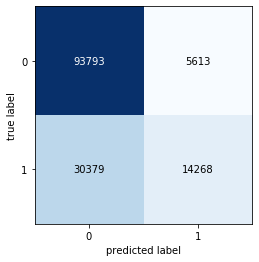

In [95]:
confu_mtx(pred_severity_logreg,testlabels)

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

scores = cross_val_score(log_reg,dftrainingfeatures_prepared,testlabels,scoring = 'f1_weighted',cv = 10)
scores

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.71087257, 0.71248644, 0.71587003, 0.71894636, 0.71819974,
       0.72109811, 0.71236927, 0.71749901, 0.71435953, 0.71829327])

In [97]:
scores.mean()

0.7159994329524156

In [98]:
skf = StratifiedKFold(shuffle = False, n_splits = 10)
scores_stratified = cross_val_score(log_reg, dftrainingfeatures_prepared, testlabels, scoring = 'f1_weighted',cv = skf)
scores_stratified

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.71087257, 0.71248644, 0.71587003, 0.71894636, 0.71819974,
       0.72109811, 0.71236927, 0.71749901, 0.71435953, 0.71829327])

In [99]:
scores_stratified.mean()

0.7159994329524156

Without Cross Validation, we obtain a weighted F1 score of 75% across our training data set. With Cross validation we obtain a mean Weighted F1 score of 71.6%. 

An important point to notice is that StratifiedKFolds made no difference to the accuracy. This is because we already stratified this data set to have the same representation of Severity Levels when we split it to Train and Test sets.

<h3> Decision Tree Classifier </h3>

In [100]:
dtree = DecisionTreeClassifier()

dtree.fit(dftrainingfeatures_prepared,testlabels)
pred_severity_dtree = dtree.predict(dftrainingfeatures_prepared)
print('Accuracy Score:', accuracy_score(testlabels, pred_severity_dtree))

Accuracy Score: 0.988906860669337


In [101]:
print(classification_report(testlabels, pred_severity_dtree))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     99406
           1       1.00      0.97      0.98     44647

    accuracy                           0.99    144053
   macro avg       0.99      0.98      0.99    144053
weighted avg       0.99      0.99      0.99    144053



In [102]:
scores_dtree = cross_val_score(dtree,dftrainingfeatures_prepared,testlabels,scoring = 'f1_weighted',cv = 10)
scores_dtree

array([0.67969879, 0.67639621, 0.6811654 , 0.67965446, 0.67850478,
       0.68535277, 0.68421178, 0.68458284, 0.67695429, 0.68220979])

In [103]:
print('Mean Accuracy:',scores_dtree.mean())

Mean Accuracy: 0.6808731115516389


In [104]:
skf_dtree = StratifiedKFold(shuffle = False, n_splits = 10)
scores_stratifieddtree = cross_val_score(dtree, dftrainingfeatures_prepared, testlabels, scoring = 'f1_weighted',cv = skf)
scores_stratifieddtree

array([0.6814581 , 0.6763928 , 0.67913866, 0.67679758, 0.67783088,
       0.6817407 , 0.68388905, 0.68620915, 0.67608161, 0.67909635])

In [105]:
print('Mean Accuracy:',scores_stratifieddtree.mean())

Mean Accuracy: 0.6798634893378617


<h3> Training without X and Y variables </h3>

In [106]:
cat_attribs_2 = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE',
              'SDOT_COLCODE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SPEEDING','ST_COLCODE','SEGLANEKEY',
              'CROSSWALKKEY','HITPARKEDCAR','TIMEOFDAY']
num_attribs_2 = ['PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']

num_pipeline = Pipeline(steps = [
                        ('select_num_attribs',prep_df(num_attribs_2)),
                        ('scaler',StandardScaler()),
                        ])

cat_pipeline = Pipeline(steps = [
                        ('select_cat_attribs',prep_df(cat_attribs_2)),
                        ('catencoder',OneHotEncoder()),
                        ])
        
full_pipeline = FeatureUnion(transformer_list = [
                        ('num_pipeline',num_pipeline),
                        ('cat_pipeline',cat_pipeline),
                        ])

dftrainingfeatures_prepared_2 = full_pipeline.fit_transform(dftrainingfeatures)
dftrainingfeatures_prepared_2

<144053x94 sparse matrix of type '<class 'numpy.float64'>'
	with 2592954 stored elements in Compressed Sparse Row format>

In [107]:
#Logistic Regression
log_reg_2 = LogisticRegression()
log_reg_2.fit(dftrainingfeatures_prepared_2,testlabels)
pred_severity_logreg_2 = log_reg_2.predict(dftrainingfeatures_prepared_2)
print('Accuracy Score:', accuracy_score(testlabels, pred_severity_logreg_2))

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy Score: 0.7501891664873345


In [108]:
scores_2 = cross_val_score(log_reg_2,dftrainingfeatures_prepared_2,testlabels,scoring = 'f1_weighted',cv = 10)
scores_2

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.71045521, 0.71259918, 0.71599805, 0.718403  , 0.71856003,
       0.71996517, 0.71259636, 0.71761613, 0.71438917, 0.71830746])

In [109]:
scores_2.mean()

0.71588897558315

No significant difference in accuracy observed in not using X and Y variables

In [110]:
dtree_2 = DecisionTreeClassifier()

dtree_2.fit(dftrainingfeatures_prepared_2,testlabels)
pred_severity_dtree_2 = dtree_2.predict(dftrainingfeatures_prepared_2)
print('Accuracy Score:', accuracy_score(testlabels, pred_severity_dtree_2))

Accuracy Score: 0.8111667233587638


In [111]:
scores_dtree_2 = cross_val_score(dtree_2,dftrainingfeatures_prepared_2,testlabels,scoring = 'f1_weighted',cv = 10)
scores_dtree_2

array([0.70468944, 0.70238097, 0.70728664, 0.70099615, 0.70862728,
       0.71139898, 0.70231591, 0.71243517, 0.70850318, 0.70465769])

<h4> As observed above, training without X and Y variables do not have a siginificant impact on the Logistic Regression Classifier, however we see a significant drop in accuracy for Decision Tree Classifier.

Moving on we shall assess Logistic Regression Classifier, Stochastic Gradient Descent Classifier with the 'hinge' loss to have a Linear Support Vector Machine, K nearest Neighbors algorithm. </h4>

<h2> Deciding between Precision vs. Recall for this dataset </h2>

In [112]:
level1_colissions = (severitylabel == 1).sum()
level1_colissions

99406

In [113]:
level2_colissions = (severitylabel == 2).sum()
level2_colissions

44647

The number of Level 2 colissions is almost half that of Level 1 colissions. This data set is skewed. Also Level 2 colissions are more severe that Level 1 colissions. Hence it is important that we capture all the Level 2 colissions due to it's higher severity as it would be dangerous to classify a Level 2 colissions as a less severe Level 1 colission. 

<h3> Due to this, the intentions moving further will be to have a high recall with an acceptable level of precision </h3> 

In [114]:
cat_attribs = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE',
              'SDOT_COLCODE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SPEEDING','ST_COLCODE','SEGLANEKEY',
              'CROSSWALKKEY','HITPARKEDCAR','TIMEOFDAY']
num_attribs = ['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']

num_pipeline = Pipeline(steps = [
                        ('select_num_attribs',prep_df(num_attribs)),
                        ('scaler',StandardScaler()),
                        ])

cat_pipeline = Pipeline(steps = [
                        ('select_cat_attribs',prep_df(cat_attribs)),
                        ('catencoder',OneHotEncoder()),
                        ])
        
full_pipeline = FeatureUnion(transformer_list = [
                        ('num_pipeline',num_pipeline),
                        ('cat_pipeline',cat_pipeline),
                        ])

In [115]:
dftrainingfeatures = dftraining.iloc[:,:-1]
severitylabel = dftraining.iloc[:,-1]

<h2> Logistic Regression </h2>

In [116]:
dftraining_logreg = full_pipeline.fit_transform(dftrainingfeatures)
dftraining_logreg

<144053x96 sparse matrix of type '<class 'numpy.float64'>'
	with 2881060 stored elements in Compressed Sparse Row format>

In [117]:
from sklearn.preprocessing import LabelEncoder
le_logreg = LabelEncoder()
#encoded severity labels
severitylabels_logreg = le.fit_transform(severitylabel)

In [118]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

In [119]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold 
skf_logreg = StratifiedKFold(shuffle = False, n_splits = 5)
log_reg_scores = cross_val_predict(log_reg, dftraining_logreg,
                                  severitylabels_logreg,
                                  cv = skf_logreg, method = 'predict_proba')

C:\Users\ASUS\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [120]:
log_reg_scores

array([[0.60392372, 0.39607628],
       [0.59250149, 0.40749851],
       [0.63280222, 0.36719778],
       ...,
       [0.0831256 , 0.9168744 ],
       [0.92555682, 0.07444318],
       [0.13329742, 0.86670258]])

In [121]:
from sklearn.metrics import precision_recall_curve
precisions_logreg, recalls_logreg, thresholds_logreg = precision_recall_curve(severitylabels_logreg, 
                                                         log_reg_scores[:,1])

In [122]:
import matplotlib.pyplot as plt
def plot_precision_recall_threshold(precisions, recalls, thresholds):
    fig,ax = plt.subplots(1,1,figsize = (15,10))
    ax.plot(thresholds,precisions[:-1],'b-', label = 'Precision')
    ax.plot(thresholds,recalls[:-1],'r-', label = 'Recall')
    ax.legend()
    ax.set_xlabel('Threshold')
    ax.grid()

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


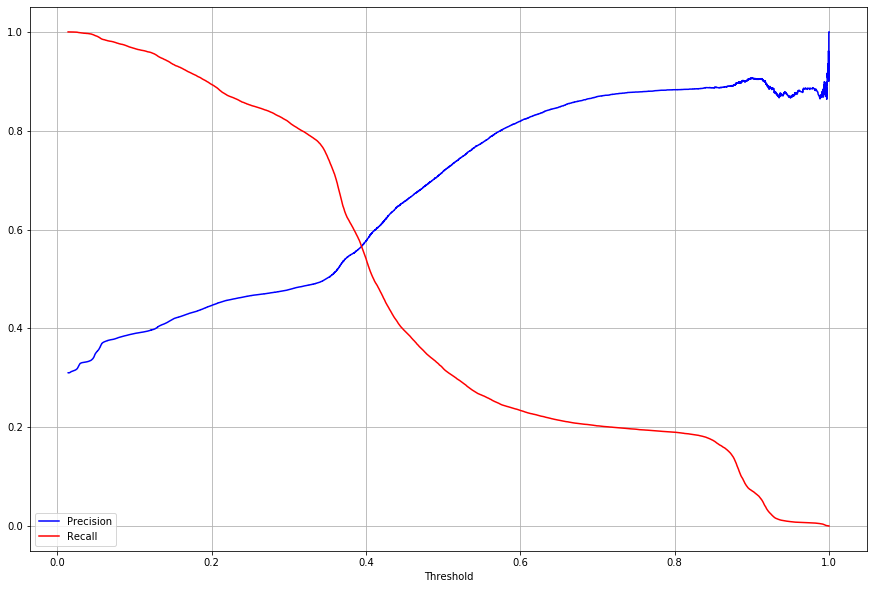

In [123]:
plot_precision_recall_threshold(precisions_logreg, recalls_logreg, thresholds_logreg)

In [124]:
def plot_precision_recall(precisions, recalls):
    fig,ax = plt.subplots(1,1,figsize = (15,10))
    ax.plot(recalls,precisions,'b-')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.grid()

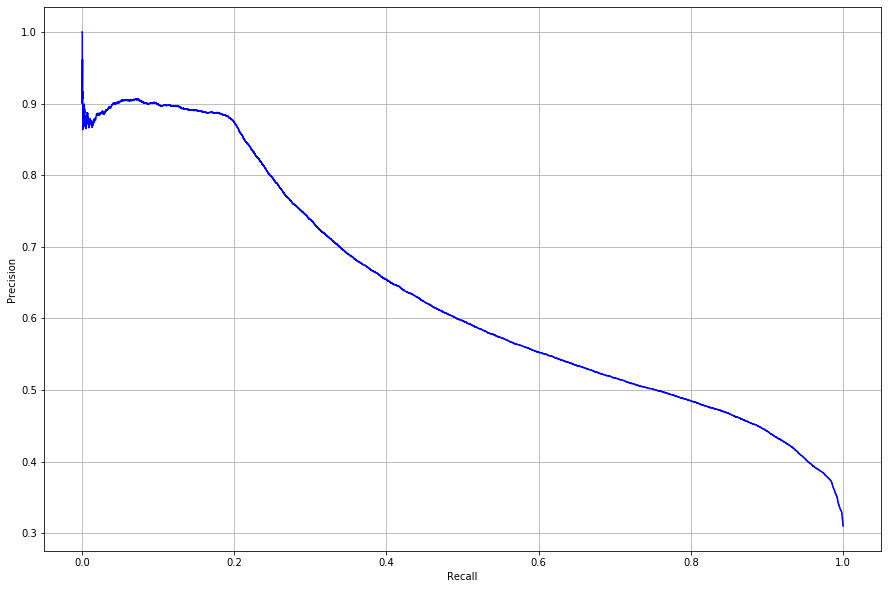

In [125]:
plot_precision_recall(precisions_logreg, recalls_logreg)

A recall of 80% is selected as we want a higher Recall in our results, however this will result in lower precision

In [126]:
idx_80recall = np.where(recalls_logreg >= 0.8)[0]
idx_80recall[-1]

69994

In [127]:
#threshold which gives 0.8 recall 

In [128]:
threshold_80 = thresholds_logreg[idx_80recall[-1]]
threshold_80

0.3170359932817952

In [129]:
log_reg_result = np.zeros(shape = (log_reg_scores.shape[0],1))
log_reg_2 = (log_reg_scores[:,1] >= threshold_80)
idx_level2 = np.where(log_reg_2 == True)[0]
log_reg_result[idx_level2] = 1

In [130]:
log_reg_result

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]])

In [131]:
from sklearn.metrics import precision_score

precision_score(severitylabels_logreg,log_reg_result)

0.4848114667318186

In [132]:
from sklearn.metrics import recall_score

recall_score(severitylabels_logreg,log_reg_result)

0.8000089591685892

In [133]:
from sklearn.metrics import confusion_matrix

In [134]:
confusion_matrix(severitylabels_logreg, log_reg_result)

array([[61450, 37956],
       [ 8929, 35718]], dtype=int64)

This model results in a relatively high recall however it causes has reduced precision. Hence we shall further try to find the optimal precision, recall and threshold

In [135]:
#trying to maximize F1 score 

f1_logreg =  2 * (precisions_logreg * recalls_logreg)/(precisions_logreg + recalls_logreg)

In [136]:
def plot_f1(f1scores, precisions, recalls, thresholds):
    fig,ax3 = plt.subplots(1,1,figsize = (15,10))
    ax3.plot(thresholds, f1scores[:-1], 'b-', label = 'F1 score')
    ax3.plot(thresholds, precisions[:-1], 'r-', label = 'Precision')
    ax3.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    ax3.legend()
    ax3.grid()
    ax3.set_xlabel('Threshold')

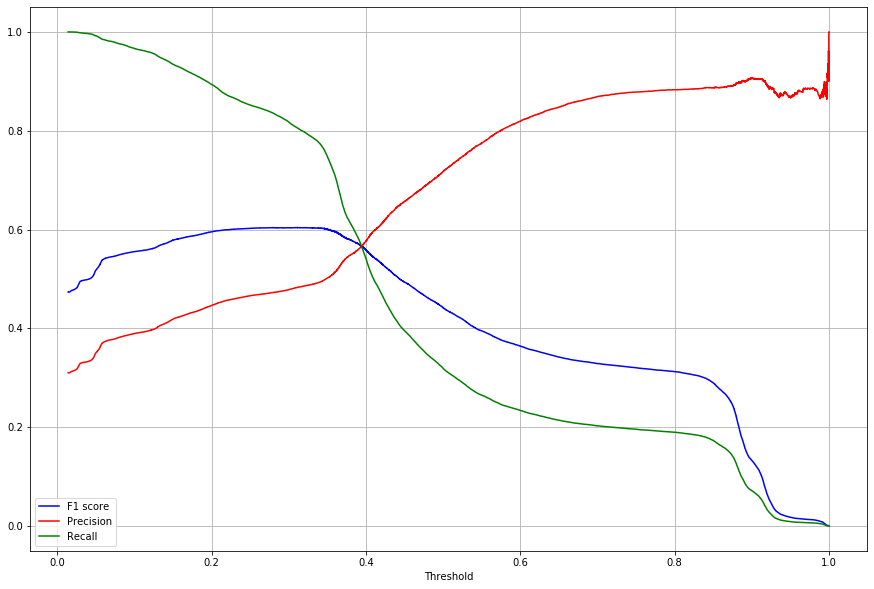

In [137]:
plot_f1(f1_logreg,precisions_logreg, recalls_logreg, thresholds_logreg)

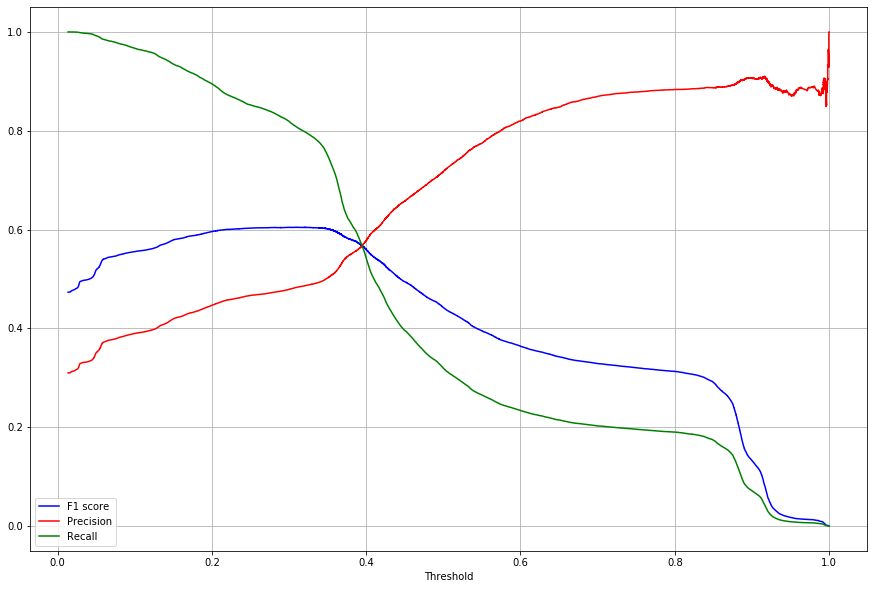

In [138]:
#train on entire train set
log_reg.fit(dftraining_logreg,severitylabels_logreg)
log_reg_prob = log_reg.predict_proba(dftraining_logreg)[:,1]
precisions_logreg2, recalls_logreg2, thresholds_logreg2 = precision_recall_curve(severitylabels_logreg, 
                                                         log_reg_prob)
f1_logreg2 =  2 * (precisions_logreg2 * recalls_logreg2)/(precisions_logreg2 + recalls_logreg2)
plot_f1(f1_logreg2,precisions_logreg2, recalls_logreg2, thresholds_logreg2)

<h2> SGD Classifier </h2> 

In [139]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)


In [140]:
dftraining_sgd = full_pipeline.fit_transform(dftrainingfeatures)
dftraining_sgd

<144053x96 sparse matrix of type '<class 'numpy.float64'>'
	with 2881060 stored elements in Compressed Sparse Row format>

In [141]:
severitylabels_sgd = le.fit_transform(severitylabel)

In [142]:
sgd_clf.fit(dftraining_sgd, severitylabels_sgd)
skf_sgd = StratifiedKFold(shuffle = False, n_splits = 5)
sgd_scores = cross_val_predict(sgd_clf, dftraining_sgd,
                                  severitylabels_sgd,
                                  cv = skf_sgd, method = 'decision_function')

In [143]:
from sklearn.metrics import precision_recall_curve
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(severitylabels_sgd, 
                                                         sgd_scores)

C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ASUS\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


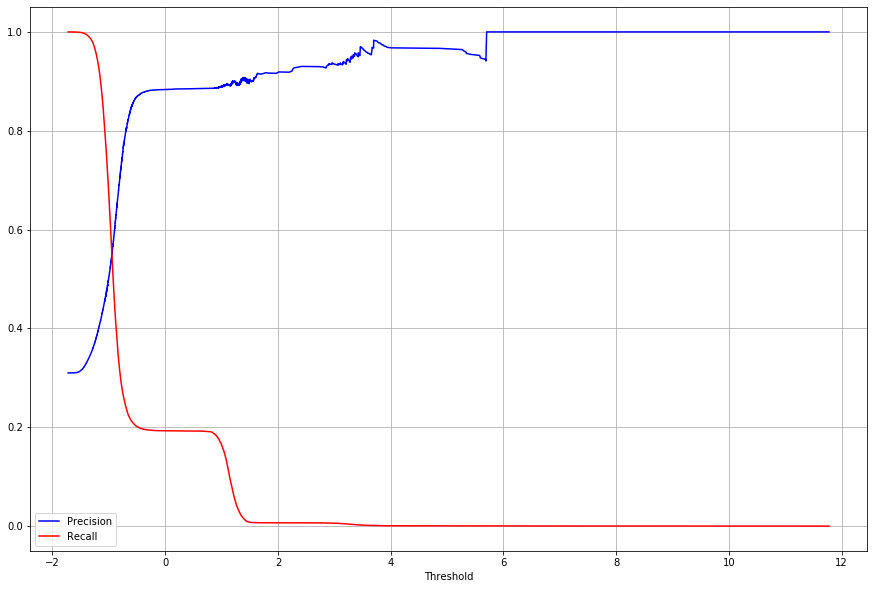

In [144]:
plot_precision_recall_threshold(precisions_sgd, recalls_sgd, thresholds_sgd)

In [145]:
f1_sgd =  2 * (precisions_sgd * recalls_sgd)/(precisions_sgd + recalls_sgd)

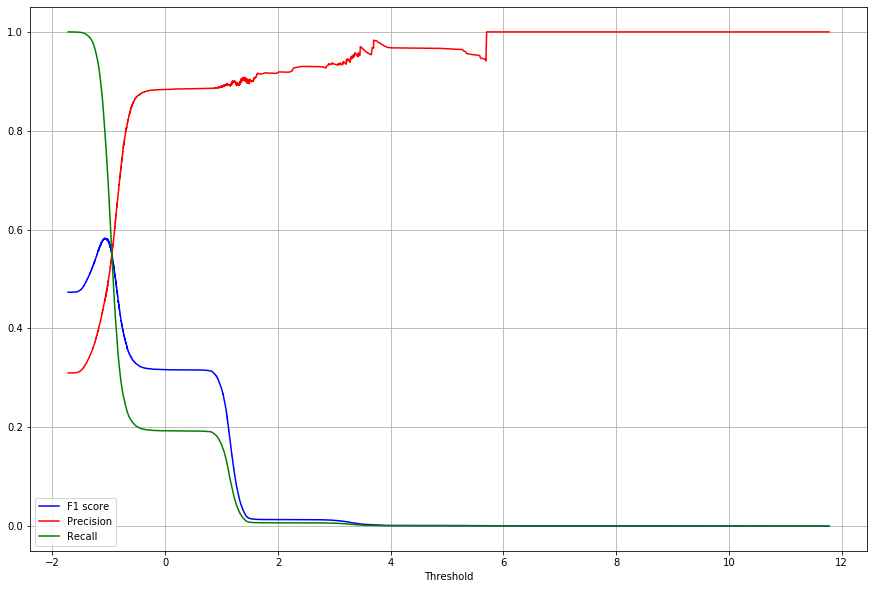

In [146]:
plot_f1(f1_sgd,precisions_sgd, recalls_sgd, thresholds_sgd)

In [147]:
np.argmax(f1_sgd)

65242

In [148]:
f1_sgd[np.argmax(f1_sgd)]

0.5820336310660674

In [149]:
precisions_sgd[np.argmax(f1_sgd)]

0.4567568946603056

In [150]:
recalls_sgd[np.argmax(f1_sgd)]

0.8020023741796761

In [151]:
threshold_sgdfinal = thresholds_sgd[np.argmax(f1_sgd)]
threshold_sgdfinal

-1.0720584159132056

In [152]:
severityscores_sgd = sgd_clf.decision_function(dftraining_sgd)

In [153]:
sgdresults = np.zeros(shape = (dftraining_sgd.shape[0],1))
temp_sgd = (severityscores_sgd >= threshold_sgdfinal)
idx_severity2 = np.where(temp_sgd == True)[0]
sgdresults[idx_severity2] = 1

In [154]:
confusion_matrix(severitylabels_sgd,sgdresults)

array([[64493, 34913],
       [11970, 32677]], dtype=int64)

In [155]:
sgdresults

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]])

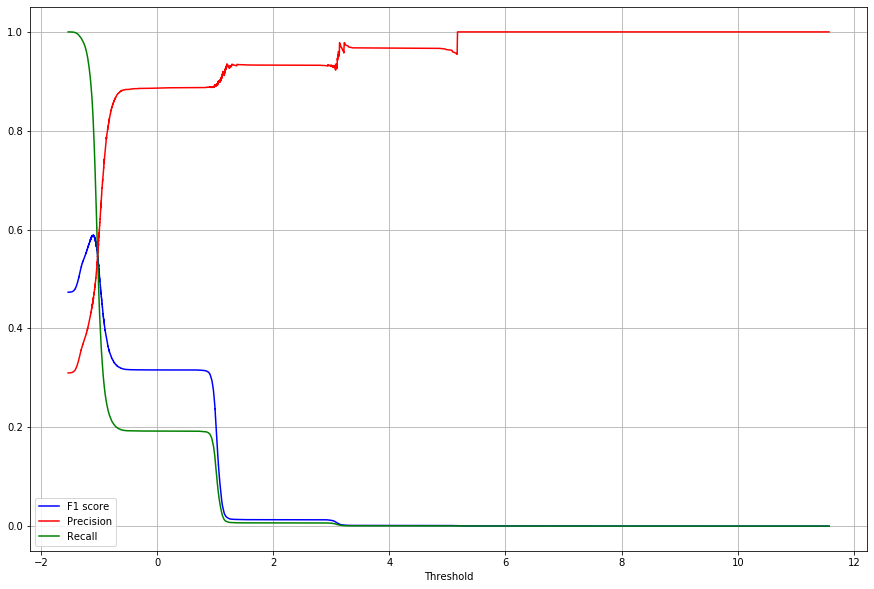

In [156]:
precisions_sgd, recalls_sgd, thresholds_sgd = precision_recall_curve(severitylabels_sgd, 
                                                         severityscores_sgd)
f1_sgd =  2 * (precisions_sgd * recalls_sgd)/(precisions_sgd + recalls_sgd)
plot_f1(f1_sgd,precisions_sgd, recalls_sgd, thresholds_sgd)

In [157]:
np.argmax(f1_sgd)
f1_sgd[np.argmax(f1_sgd)]

0.5881807610048061

In [158]:
precisions_sgd[np.argmax(f1_sgd)]

0.4617348893031332

In [159]:
recalls_sgd[np.argmax(f1_sgd)]

0.8099984321454969

In [160]:
threshold_sgdfinal = thresholds_sgd[np.argmax(f1_sgd)]
threshold_sgdfinal

-1.0969357952918506

In [161]:
sgdresults = np.zeros(shape = (dftraining_sgd.shape[0],1))
temp_sgd = (severityscores_sgd >= threshold_sgdfinal)
idx_severity2 = np.where(temp_sgd == True)[0]
sgdresults[idx_severity2] = 1

In [162]:
confusion_matrix(severitylabels_sgd,sgdresults)

array([[57248, 42158],
       [ 8483, 36164]], dtype=int64)

<h2> KNearest Neighbors Classifier </h2>

In [163]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [164]:
dftraining_knn = full_pipeline.fit_transform(dftrainingfeatures)
dftraining_knn

<144053x96 sparse matrix of type '<class 'numpy.float64'>'
	with 2881060 stored elements in Compressed Sparse Row format>

In [165]:
severitylabels_knn = le.fit_transform(severitylabel)

In [166]:
knn.fit(dftraining_knn, severitylabels_knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [167]:
skf_knn = StratifiedKFold(shuffle = False, n_splits = 5)
knn_scores = cross_val_predict(knn,dftraining_knn, severitylabels_knn,
                              cv = skf_knn, 
                              method = 'predict_proba')

In [168]:
precisions_knn, recalls_knn, thresholds_knn = precision_recall_curve(severitylabels_knn,
                                                                    knn_scores[:,1])

In [169]:
f1_knn =  2 * (precisions_knn * recalls_knn)/(precisions_knn + recalls_knn)

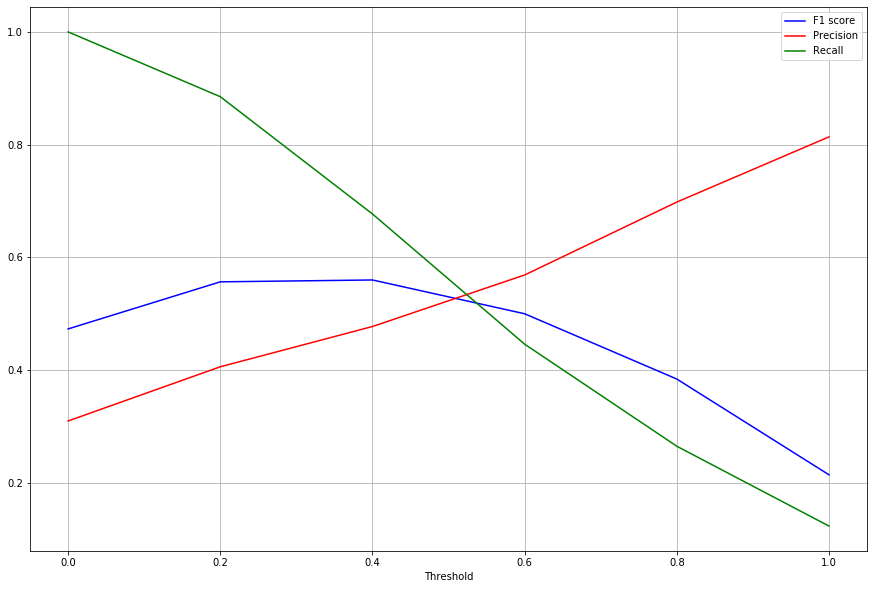

In [170]:
plot_f1(f1_knn,precisions_knn, recalls_knn, thresholds_knn)

A Threshold of 0.2 results in a precision of 0.41 and a recall of 0.89 and high F1 score. This is a better result than both Logistic Regression and SGDClassifier with a linear SVM

In [171]:
knn.fit(dftraining_knn, severitylabels_knn)
knn_scores_trainset = knn.predict_proba(dftraining_knn)
knn_scores_trainset

array([[0.8, 0.2],
       [0.2, 0.8],
       [1. , 0. ],
       ...,
       [0. , 1. ],
       [1. , 0. ],
       [0. , 1. ]])

In [172]:
knnresults = np.zeros(shape = (dftraining_knn.shape[0],1))
temp_knn = (knn_scores_trainset[:,1] >= 0.2)
idx_severity2 = np.where(temp_knn == True)[0]
knnresults[idx_severity2] = 1
knnresults

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]])

In [173]:
precision_score(severitylabels_knn,knnresults)

0.4574572728390508

In [174]:
recall_score(severitylabels_knn,knnresults)

0.9999776020785272

In [175]:
severitylabels_knn

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [176]:
knnresults

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [0.],
       [1.]])

In [177]:
confusion_matrix(severitylabels_knn,knnresults)

array([[46456, 52950],
       [    1, 44646]], dtype=int64)

As seen above the KNN classifer gives better recall compared to other classifiers in the Cross Validation sets and also a very high recall in the original training set. The extremely high recall can be a result of overfitting, nevertheless it's performance is much better than that of Logistic Regression and Stochastic Gradient Classifier with a linear SVM. 

<h3> ROC AUC Score on Training data</h3>

In [178]:
from sklearn.metrics import roc_auc_score

In [179]:
#logistic regression
roc_auc_score(severitylabels_logreg,log_reg_prob)

0.7912008533006483

In [180]:
#SGDClassifier
roc_auc_score(severitylabels_sgd,severityscores_sgd)

0.7740008740367172

In [181]:
#KNN Classifier
roc_auc_score(severitylabels_knn,knn_scores_trainset[:,1])

0.8769706005336988

<h3> ROC AUC Score on Cross Validation data</h3>

In [182]:
#logistic regression
roc_auc_score(severitylabels_logreg,log_reg_scores[:,1])

0.7904203402867095

In [183]:
#SGDClassifier
roc_auc_score(severitylabels_sgd,sgd_scores)

0.7692081346651526

In [184]:
#KNN Classifier
roc_auc_score(severitylabels_knn,knn_scores[:,1])

0.734346662488281

<h1> Applying the KNN Model on the Test Data </h1>

In [189]:
dftesting = strat_test_set.copy()

In [196]:
testsetlabels = dftesting.iloc[:,-1]
severitylabels_test = le.fit_transform(testsetlabels)
severitylabels_test

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

In [192]:
dftestingfeatures = dftesting.iloc[:,:-1]
dftestingfeatures.head()

X          Y      ADDRTYPE COLLISIONTYPE  PERSONCOUNT  \
147124 -122.332619  47.603251         Block    Rear Ended            2   
6595   -122.267145  47.544274  Intersection        Angles            2   
37864  -122.344896  47.717173         Block         Other            2   
34456  -122.344361  47.728674         Block         Other            4   
12482  -122.302761  47.610023  Intersection    Pedestrian            2   

        PEDCOUNT  PEDCYLCOUNT  VEHCOUNT  \
147124         0            0         2   
6595           0            0         2   
37864          0            0         2   
34456          0            0         2   
12482          1            0         1   

                                  JUNCTIONTYPE  \
147124    Mid-Block (but intersection related)   
6595    At Intersection (intersection related)   
37864                        Driveway Junction   
34456     Mid-Block (but intersection related)   
12482   At Intersection (intersection related)   

                                             SDOT_COLCODE UNDERINFL   WEATHER  \
147124       MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END         0     Clear   
6595    MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0     Clear   
37864   MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0   Raining   
34456   MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...         0     Clear   
12482                     MOTOR VEHCILE STRUCK PEDESTRIAN         0  Overcast   

       ROADCOND                LIGHTCOND  SPEEDING  \
147124      Dry                 Daylight         0   
6595        Dry  Dark - Street Lights On         0   
37864       Wet                 Daylight         0   
34456       Dry                     Dusk         0   
12482       Wet                 Daylight         0   

                                               ST_COLCODE SEGLANEKEY  \
147124  From same direction - both going straight - on...      Lane1   
6595                                    Entering at angle      Lane1   
37864                     One car leaving driveway access      Lane1   
34456                    From same direction - all others      Lane1   
12482              Vehicle going straight hits pedestrian      Lane1   

       CROSSWALKKEY  HITPARKEDCAR      TIMEOFDAY  
147124        Lane1             0        Evening  
6595          Lane1             0          Night  
37864         Lane1             0        Evening  
34456         Lane1             0        Evening  
12482         Lane1             0  Early Morning

In [193]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
cat_attribs = ['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE',
              'SDOT_COLCODE','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','SPEEDING','ST_COLCODE','SEGLANEKEY',
              'CROSSWALKKEY','HITPARKEDCAR','TIMEOFDAY']
num_attribs = ['X','Y','PERSONCOUNT','PEDCOUNT','PEDCYLCOUNT','VEHCOUNT']

num_pipeline = Pipeline(steps = [
                        ('select_num_attribs',prep_df(num_attribs)),
                        ('scaler',StandardScaler()),
                        ])

cat_pipeline = Pipeline(steps = [
                        ('select_cat_attribs',prep_df(cat_attribs)),
                        ('catencoder',OneHotEncoder()),
                        ])
        
full_pipeline = FeatureUnion(transformer_list = [
                        ('num_pipeline',num_pipeline),
                        ('cat_pipeline',cat_pipeline),
                        ])

In [194]:
dftestingfeatures_prepared = full_pipeline.fit_transform(dftestingfeatures)
dftestingfeatures_prepared

<36014x96 sparse matrix of type '<class 'numpy.float64'>'
	with 720280 stored elements in Compressed Sparse Row format>

In [195]:
knn_scores_testset = knn.predict_proba(dftestingfeatures_prepared)
knn_scores_testset

array([[0.6, 0.4],
       [0.2, 0.8],
       [0.8, 0.2],
       ...,
       [0.4, 0.6],
       [0.8, 0.2],
       [0. , 1. ]])

In [197]:
knn_testresults = np.zeros(shape = (dftestingfeatures_prepared.shape[0],1))
temp_knn = (knn_scores_testset[:,1]>=0.2)
idx_true = np.where(temp_knn == True)[0]
knn_testresults[idx_true] = 1
knn_testresults

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [199]:
#calculate precision of the data on the test set
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision_score(severitylabels_test,knn_testresults)

0.41012469447781597

In [200]:
recall_score(severitylabels_test,knn_testresults)

0.8869378247625873

In [201]:
confusion_matrix(severitylabels_test,knn_testresults)

array([[10613, 14239],
       [ 1262,  9900]], dtype=int64)

<h1> Conclusion </h1>


<h4> The intention of this project was to build a model which emphasises recall of the more severe colission categories, such that these scenarios can be addressed to build better safety measures against them. Furthermore the proportion of Severity Level 2 cases was much lower than Level 1 cases, hence the dataset was skewed. 

Due to the above reasons, accuracy was not an appropriate goal of this model, instead higher recall is of the major interest. Even if scenarios identified are mistakenly identified to be of the higher Severity Level 2, it is alright as it would only improve safety measures against such scenarios too </h4>

Approach in terms of data wrangling:
- A number of unnecessary columns have been dropped
- A new feature called Time of Day has been extracted using Incident Timings 
- ST_COLCODE and SDOT_COLCODE have been made into concise features with inclusion of 'Other' and made to more meaningful features than are easier to One Hot Encode. 
- Categorical variables and Continuous variables have been assessed using Chi Squared Value and Recursive Feature Elimination

Approach in terms of Building a predictive model:
- A stratified dataset split was carried out creating a stratified test and training set. 
- Decision trees were tried out however they overfit on the cross validation set. 
- Logistic regression, SGD with linear SVM and KNN were tested on the cross validation sets. 
- Precision, Recall and ROC AUC was measured for all 3 models and it KNN was selected to be the best model

The KNN model that was **trained on the training set** was applied on the test model and a high recall of 89% was achieved with respect to Severity Level 2 as required. 



